In [1]:
from IPython.display import HTML
import time

handle = display(HTML("""<marquee>👌</marquee>"""), display_id='html_marquee1')
time.sleep(2)
handle = display(HTML("""<marquee>~ "There is a time for many words, and there is also a time for sleep." – Homer, The Odyssey</marquee>"""), display_id='html_marquee1', update=True)

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Executive Summary</div>

<div class="alert alert-block alert-info"> 📌 <b>Summary</b>: This notebook is intended to 
<ul>
    <li>Provide the exhaustive EDA on the dataset for <a href="https://www.kaggle.com/competitions/child-mind-institute-detect-sleep-states" target='_blannk'>Child Mind Institute - Detect Sleep States contest</a></li>
    <li>Perform the time series analysis of the sleeping events</li>
    <li>Summarize and evaluate feature engineering ideas (such a feature engineering is useful if you are going to tackle the prediction challenge as a tabular classification problem rather then a time series forecasting task)</li>
</ul></div>

<div class="alert alert-block alert-success"> 🧰 <b>Key highlights</b>:
    <ul>
        <li>TBD</li>
    </ul>
</div> 

Based on the insights derived in the EDA / data analytics drills across this notebook, the solid ML experiments can be set up down the road.

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Status of This Notebook</div>

<div style="color:black;
           display:fill;
           border-radius:5px;
           background-color:#fad3cf;
           font-size:90%;
           font-family:Verdana;
           letter-spacing:0.5px">
<b>Note to Readers:</b> It is essentially work in progress as of this moment. The incremental updates in future will add more content to the respective sections of the notebook.
</div>

In [2]:
import gc
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline

from colorama import Fore, Style, init
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Color printing
# inspired by https://www.kaggle.com/code/ravi20076/sleepstate-eda-baseline
def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    "Prints color outputs using colorama using a text F-string";
    print(style + color + text + Style.RESET_ALL);

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">About the Competition and Its Dataset</div>

The **goal of the competition** is to detect sleep onset and wake. We are requested to develop a model trained on wrist-worn accelerometer data in order to determine a person's sleep state.

The training dataset is composed of
- The Multi-day recordings of wrist-worn accelerometer (provided as a parquet file).
- The labelling file with the data annotated with two event types: **onset**, the beginning of sleep, and **wakeup**, the end of the sleeping time (provided as a CSV file).

Both data files represent the essential time series-type data.

For the testing set, only the accelerometer-based data (in parquet format) are provided.

Essential summary on the data for the contest is quoted below, as per the note from the contest hosts

<blockquote>
    <div class="alert alert-block alert-success"> ✅ <b>Data description</b>: The dataset comprises about 500 multi-day recordings of wrist-worn accelerometer data annotated with two event types: onset, the beginning of sleep, and wakeup, the end of sleep. Your task is to detect the occurrence of these two events in the accelerometer series.<br><br>

While sleep logbooks remain the gold-standard, when working with accelerometer data we refer to sleep as the longest single period of inactivity while the watch is being worn. For this data, we have guided raters with several concrete instructions:

<ul>
    <li>A single sleep period must be at least 30 minutes in length</li>
    <li>A single sleep period can be interrupted by bouts of activity that do not exceed 30 consecutive minutes</li>
<li>No sleep windows can be detected unless the watch is deemed to be worn for the duration</li>
<li>The longest sleep window during the night is the only one which is recorded</li>
<li>If no valid sleep window is identifiable, neither an onset nor a wakeup event is recorded for that night.</li>
<li>Sleep events do not need to straddle the day-line, and therefore there is no hard rule defining how many may occur within a given period. However, no more than one window should be assigned per night. For example, it is valid for an individual to have a sleep window from 01h00–06h00 and 19h00–23h30 in the same calendar day, though assigned to consecutive nights.</li>
<li>There are roughly as many nights recorded for a series as there are 24-hour periods in that series.
</ul><br>
        
Though each series is a continuous recording, there may be periods in the series when the accelerometer device was removed. These period are determined as those where suspiciously little variation in the accelerometer signals occur over an extended period of time, which is unrealistic for typical human participants. Events are not annotated for these periods, and you should attempt to refrain from making event predictions during these periods: an event prediction will be scored as false positive.<br>

Each data series represents this continuous (multi-day/event) recording for a unique experimental subject.
    </div>
</blockquote>

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">train_series.parquet Details</div>

This file represents series to be used as training data. Each series is a continuous recording of accelerometer data for a single subject spanning many days.

The table below summarizes the structure of the initial accelerometer data provided:

<style>
#features {
  font-family: Arial, Helvetica, sans-serif;
  border-collapse: collapse;
  width: 100%;
}

#features td, #features th {
  border: 1px solid #ddd;
  padding: 8px;
}

#features tr:nth-child(even){background-color: #f2f2f2;}

#features tr:hover {background-color: #ddd;}

#features th {
  padding-top: 12px;
  padding-bottom: 12px;
  text-align: left;
  background-color: #CBC3E3;
  color: white;
}
</style>

<table id="features">
    <tr>
        <th>Attribute</th>
        <th>Description</th>
        <th>Comments</th>
    </tr>
    <tr>
      <td><b><i>series_id</i></b></td>
      <td>Unique identifier for each accelerometer series</td>
      <td>&nbsp;</td>
    </tr>
    <tr>
      <td><b><i>step</i></b></td>
      <td>An integer timestep for each observation within a series.</td>
      <td>It is unique within a series</td>
    </tr>
    <tr>
      <td><b><i>timestamp</i></b></td>
      <td>A corresponding datetime in ISO 8601 format: <i>%Y-%m-%dT%H:%M:%S%z.</i></td>
      <td>&nbsp;</td>
    </tr>
    <tr>
      <td><b><i>anglez</i></b></td>
      <td>As calculated and described by the GGIR package, z-angle is a metric derived from individual accelerometer components that is commonly used in sleep detection, and refers to the angle of the arm relative to the vertical axis of the body</td>
        <td>You can refer to <a href="https://cran.r-project.org/web/packages/GGIR/vignettes/GGIR.html#4_Inspecting_the_results" target="_blank">Accelerometer data processing with GGIR</a> for more details</td>
    </tr>
    <tr>
      <td><b><i>enmo</i></b></td>
      <td>As calculated and described by the GGIR package, ENMO is the Euclidean Norm Minus One of all accelerometer signals, with negative values rounded to zero. While no standard measure of acceleration exists in this space, this is one of the several commonly computed features</td>
      <td>You can refer to <a href="https://cran.r-project.org/web/packages/GGIR/vignettes/GGIR.html#4_Inspecting_the_results" target="_blank">Accelerometer data processing with GGIR</a> for more details</td>
    </tr>
</table>

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">test_series.parquet Details</div>

This file contains the details on the series to be used as the test data, containing the same fields as above. The goal is to predict event occurrences for series in this file.


## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">train_events.csv Details</div>

This file represents series to be used as training data. Each series is a continuous recording of accelerometer data for a single subject spanning many days.

The table below summarizes the structure of the initial accelerometer data provided:

<style>
#features {
  font-family: Arial, Helvetica, sans-serif;
  border-collapse: collapse;
  width: 100%;
}

#features td, #features th {
  border: 1px solid #ddd;
  padding: 8px;
}

#features tr:nth-child(even){background-color: #f2f2f2;}

#features tr:hover {background-color: #ddd;}

#features th {
  padding-top: 12px;
  padding-bottom: 12px;
  text-align: left;
  background-color: #CBC3E3;
  color: white;
}
</style>

<table id="features">
    <tr>
        <th>Attribute</th>
        <th>Description</th>
        <th>Comments</th>
    </tr>
    <tr>
      <td><b><i>series_id</i></b></td>
      <td>Unique identifier for each accelerometer series, corresponding to the identifies for each series of accelerometer data in <i>train_series.parquet.</i></td>
      <td>&nbsp;</td>
    </tr>
    <tr>
      <td><b><i>night</i></b></td>
        <td>An enumeration of potential <i>onset / wakeup</i> event pairs. At most one pair of events can occur for each night.</td>
      <td>&nbsp;</td>
    </tr>
    <tr>
      <td><b><i>event</i></b></td>
        <td>The type of event, whether <i>onset</i> or <i>wakeup</i>.</td>
      <td>&nbsp;</td>
    </tr>
    <tr>
      <td><b><i>step</i></b></td>
      <td>An integer timestep for each observation within a series.</td>
      <td>It is unique within a series</td>
    </tr>
    <tr>
      <td><b><i>timestamp</i></b></td>
      <td>The recorded time of occurence of the event in the accelerometer series in ISO 8601 format: <i>%Y-%m-%dT%H:%M:%S%z.</i></td>
      <td>&nbsp;</td>
    </tr>
</table>

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Reading Data</div>

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Initial Data Inspection</div>

First of all, we are going to read the data in memory.

Since the size of the dataset (especially, its parquet parts with accelerometer data feeds) is quite big, time- and memory-effective data loading should be implemented.

Therefore, we are going to use Polars, the fast alternative to Pandas. So, out data loading strategy is going to be as follows

- use Polars to read both the parquet and csv files in memory
- convert the output to the Pandas dataframes to enable data analytics and EDA experiments as needed
- as a part of such data loading, we will also extract the features from timestamp values in series and events data (namely, we will decompose the timestamps into year, month, day, and hour components to enable insight-reach EDA down the road)
- compress the series data in memory by reducing the RAM usage by the respective Pandas dataframes

<div class="alert alert-block alert-info"> ✅ <b>Note</b>: Pandas is an essential Python library for Data Science. But its biggest downside is that it can be slow for operations on large datasets. Polars is a Pandas alternative designed to process data faster. You can refer to the references provided in "References" chapter below to learn more about Polars.</div>


In [4]:
%%time
# inspired by https://www.kaggle.com/code/enricomanosperti/detect-sleep-states-first-preprocessing-and-eda
import polars as pl
train_series = (pl.scan_parquet('/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet')
                .with_columns(
                    (
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.year().alias("year")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.month().alias("month")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.day().alias("day")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.hour().alias("hour")),
                    )
                )
                .collect()
                .to_pandas()
               )

CPU times: user 1min 4s, sys: 25 s, total: 1min 29s
Wall time: 56.5 s


In [5]:
train_series.head().style.set_caption("Sample of data in the train series data file"). \
set_properties(**{'border': '1.3px solid blue',
                          'color': 'grey'})

,series_id,step,timestamp,anglez,enmo,year,month,day,hour
0,038441c925bb,0,2018-08-14 15:30:00,2.636700,0.021700,2018,8,14,15
1,038441c925bb,1,2018-08-14 15:30:05,2.636800,0.021500,2018,8,14,15
2,038441c925bb,2,2018-08-14 15:30:10,2.637000,0.021600,2018,8,14,15
3,038441c925bb,3,2018-08-14 15:30:15,2.636800,0.021300,2018,8,14,15
4,038441c925bb,4,2018-08-14 15:30:20,2.636800,0.021500,2018,8,14,15


In [6]:
train_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127946340 entries, 0 to 127946339
Data columns (total 9 columns):
 #   Column     Dtype         
---  ------     -----         
 0   series_id  object        
 1   step       uint32        
 2   timestamp  datetime64[ns]
 3   anglez     float32       
 4   enmo       float32       
 5   year       int32         
 6   month      uint32        
 7   day        uint32        
 8   hour       uint32        
dtypes: datetime64[ns](1), float32(2), int32(1), object(1), uint32(4)
memory usage: 5.2+ GB


In [7]:
%%time
train_events = (pl.scan_csv('/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv')
                .with_columns(
                    (
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.year().alias("year")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.month().alias("month")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.day().alias("day")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.hour().alias("hour")),
                    )
                )
                .collect()
                .to_pandas()
               )

CPU times: user 37.8 ms, sys: 4.32 ms, total: 42.1 ms
Wall time: 54.1 ms


In [8]:
train_events.head().style.set_caption("Sample of data in the train events data file"). \
set_properties(**{'border': '1.3px solid blue',
                          'color': 'grey'})

,series_id,night,event,step,timestamp,year,month,day,hour
0,038441c925bb,1,onset,4992.000000,2018-08-14 22:26:00,2018.000000,8.000000,14.000000,22.000000
1,038441c925bb,1,wakeup,10932.000000,2018-08-15 06:41:00,2018.000000,8.000000,15.000000,6.000000
2,038441c925bb,2,onset,20244.000000,2018-08-15 19:37:00,2018.000000,8.000000,15.000000,19.000000
3,038441c925bb,2,wakeup,27492.000000,2018-08-16 05:41:00,2018.000000,8.000000,16.000000,5.000000
4,038441c925bb,3,onset,39996.000000,2018-08-16 23:03:00,2018.000000,8.000000,16.000000,23.000000


In [9]:
train_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14508 entries, 0 to 14507
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   series_id  14508 non-null  object        
 1   night      14508 non-null  int64         
 2   event      14508 non-null  object        
 3   step       9585 non-null   float64       
 4   timestamp  9585 non-null   datetime64[ns]
 5   year       9585 non-null   float64       
 6   month      9585 non-null   float64       
 7   day        9585 non-null   float64       
 8   hour       9585 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 1020.2+ KB


In [10]:
%%time
test_series = (pl.scan_parquet('/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet')
                .with_columns(
                    (
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.year().alias("year")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.month().alias("month")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.day().alias("day")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.hour().alias("hour")),
                    )
                )
                .collect()
                .to_pandas()
               )

CPU times: user 5.84 ms, sys: 4.18 ms, total: 10 ms
Wall time: 11.4 ms


In [11]:
test_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   series_id  450 non-null    object        
 1   step       450 non-null    uint32        
 2   timestamp  450 non-null    datetime64[ns]
 3   anglez     450 non-null    float32       
 4   enmo       450 non-null    float32       
 5   year       450 non-null    int32         
 6   month      450 non-null    uint32        
 7   day        450 non-null    uint32        
 8   hour       450 non-null    uint32        
dtypes: datetime64[ns](1), float32(2), int32(1), object(1), uint32(4)
memory usage: 19.5+ KB


Before we do the analytical drills, let's optimize the RAM consumption of the notebook, with compressing the series data in memorty.

In [12]:
%%time
# inspired by https://www.kaggle.com/code/renatoreggiani/reduce-memory-usage-zzzs-cmi
# with tweaks determined by the selected polars loading strategy
# tweaks inspired by https://github.com/softhints/Pandas-Tutorials/blob/master/column/3.check-dtype-column-columns-pandas-dataframe.ipynb
from pandas.api.types import is_datetime64_ns_dtype
def reduce_mem_usage(df):
    """ iterate through all numeric columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_mem:.2f} MB')
    
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and not is_datetime64_ns_dtype(df[col]):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float16)

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    decrease = 100 * (start_mem - end_mem) / start_mem
    print(f'Decreased by {decrease:.2f}%')
    
    return df

train_series = reduce_mem_usage(train_series)

Memory usage of dataframe is 5368.84 MB
Memory usage after optimization is: 3904.61 MB
Decreased by 27.27%
CPU times: user 7.16 s, sys: 732 ms, total: 7.9 s
Wall time: 7.78 s


In [13]:
%%time
test_series = reduce_mem_usage(test_series)

Memory usage of dataframe is 0.02 MB
Memory usage after optimization is: 0.01 MB
Decreased by 31.61%
CPU times: user 13.9 ms, sys: 1.94 ms, total: 15.8 ms
Wall time: 14.8 ms


## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Missing Values Review: Train Events Data</div>

Let's review the spread of the missing values in the train events data.

In [14]:
for col in train_events.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col,100*(train_events[col].isnull().sum()/train_events[col].shape[0]))
    PrintColor(f"\n---> {msg}");
    #print(msg)


---> column:  series_id	 Percent of NaN value: 0.00%

---> column:      night	 Percent of NaN value: 0.00%

---> column:      event	 Percent of NaN value: 0.00%

---> column:       step	 Percent of NaN value: 33.93%

---> column:  timestamp	 Percent of NaN value: 33.93%

---> column:       year	 Percent of NaN value: 33.93%

---> column:      month	 Percent of NaN value: 33.93%

---> column:        day	 Percent of NaN value: 33.93%

---> column:       hour	 Percent of NaN value: 33.93%


Now, let's visualize the missing values spread in the dataset. 

<div class="alert alert-block alert-info"> ✅ <b>Tip</b>: The good instrument to quickly visualize the missing values in a dataset is the specialized library - <i><b>missingno</b></i>. We are going to demonstrate it below.
</div>

First of all, we will look at the ratio of the missing values as a bar chart

<Axes: >

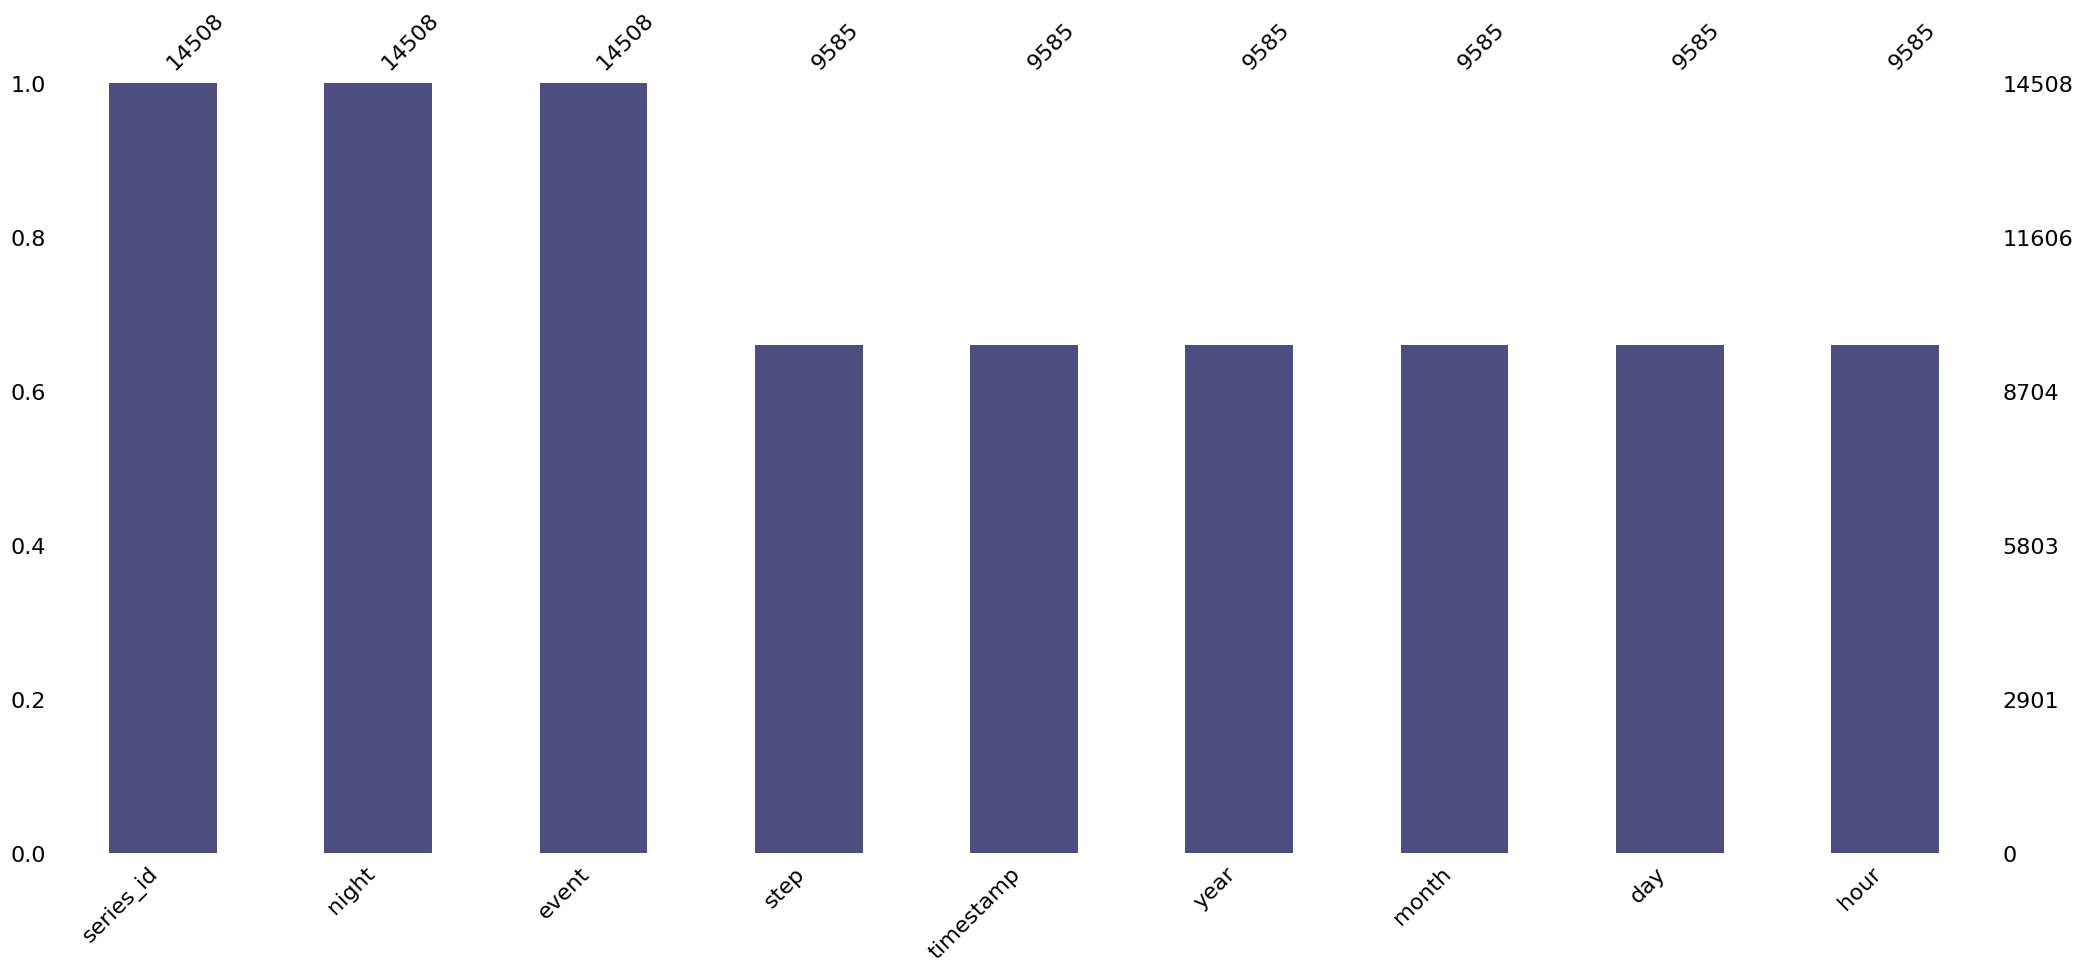

In [15]:
import missingno as msno

msno.bar(train_events, color=(0.3,0.3,0.5))

Now we are going to look at the actual records inn the train events data affected in the matrix view

<Axes: >

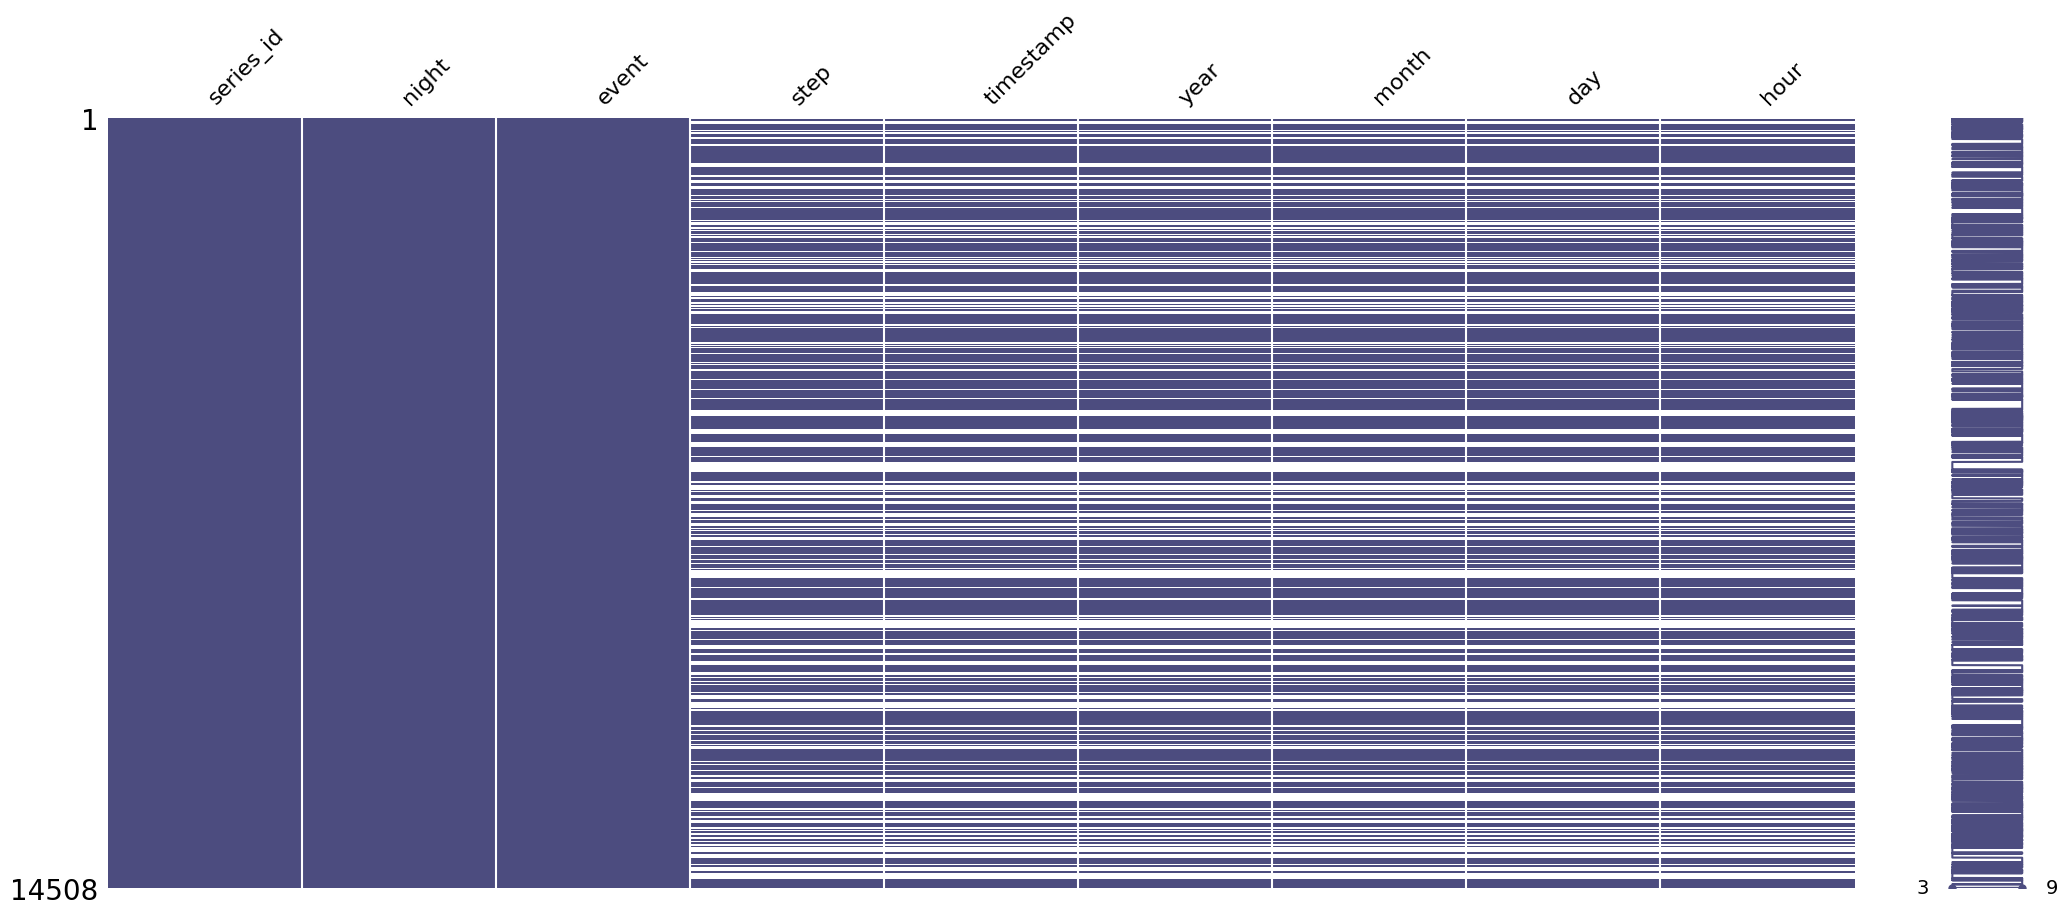

In [16]:
msno.matrix(train_events, color=(0.3,0.3,0.5))

As we can see, 

- There is a fraction of the series with incomplete labelling of sleeping/wakening events. 
- As we can see from the diagrams, the event labelling for such series is somewhat shrinked by certain dates.
- Another insight is, the % of missing data in *step* and *timestamp* attributes is quite high (*33.93%*). 

It makes it really unproductive to attempt to impute such missing values with any synthetical approach as it would introduce the type 2 noise in our dataset. If we do not find the logically determinant way of filling the missing values, it  would be better to shrink the incompletely labelled series from the training set exposed to the ML experiments down the road.

Let's look at the training events deeper to understand the impact of the shrinked labelling for some of the time series.

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Missing Values Review: Train Series Data</div>

Let's review the spread of the missing values in the train series data.

In [17]:
for col in train_series.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col,100*(train_series[col].isnull().sum()/train_series[col].shape[0]))
    PrintColor(f"\n---> {msg}");
    #print(msg)


---> column:  series_id	 Percent of NaN value: 0.00%

---> column:       step	 Percent of NaN value: 0.00%

---> column:  timestamp	 Percent of NaN value: 0.00%

---> column:     anglez	 Percent of NaN value: 0.00%

---> column:       enmo	 Percent of NaN value: 0.00%

---> column:       year	 Percent of NaN value: 0.00%

---> column:      month	 Percent of NaN value: 0.00%

---> column:        day	 Percent of NaN value: 0.00%

---> column:       hour	 Percent of NaN value: 0.00%


We find that there are no missing values in the train series data (accelerometer-based time series).

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Labelling Coverage for Train Series Data</div>

Let's review how many seires are fully labelled with the events.

In [18]:
# base statistics
train_events.describe(include='all').style.set_caption("Summary statistics for training events"). \
set_properties(**{'border': '1.3px solid blue',
                          'color': 'grey'})

,series_id,night,event,step,timestamp,year,month,day,hour
count,14508,14508.000000,14508,9585.000000,9585,9585.000000,9585.000000,9585.000000,9585.000000
unique,277,nan,2,nan,nan,nan,nan,nan,nan
top,78569a801a38,nan,onset,nan,nan,nan,nan,nan,nan
freq,168,nan,7254,nan,nan,nan,nan,nan,nan
mean,nan,15.120072,nan,214352.123944,2018-07-01 05:31:32.450704128,2017.997809,6.496609,15.987585,12.127804
min,nan,1.000000,nan,936.000000,2017-08-05 22:44:00,2017.000000,1.000000,1.000000,0.000000
25%,nan,7.000000,nan,95436.000000,2018-01-25 22:09:00,2018.000000,3.000000,8.000000,6.000000
50%,nan,14.000000,nan,200604.000000,2018-06-16 23:05:00,2018.000000,6.000000,16.000000,8.000000
75%,nan,21.000000,nan,317520.000000,2018-12-17 06:36:00,2018.000000,10.000000,24.000000,21.000000
max,nan,84.000000,nan,739392.000000,2019-07-05 05:33:00,2019.000000,12.000000,31.000000,23.000000


We find that
- There are *277* unique series in the train events (labels) file
- The length of the series ranges from *1 to 84*  nights, with the median to be *14* nights and the average length to be around *15* nights
- The observations that collected series data were between *'2017-08-05 22:44:00'* and *'2019-07-05 05:33:00'*, UTC 
- The series with the most labelled events has *id = '78569a801a38'*
- There are NaN values in the *step* column, which means that we can not use those instances for generating the label
- It may sound we will have to choose only those series that do not have any missing steps events

Now, let's visualize how many training series have full coverage with event labelling

In [19]:
series_steps = train_events.groupby(['series_id'])['step'].apply(lambda x: x.isnull().any())

frame = {'series_id': series_steps.index,
         'has_missing_labels': series_steps}
 
# Creating DataFrame by passing Dictionary
agg_data = pd.DataFrame(frame)

dfg = agg_data['has_missing_labels'].value_counts().reset_index()
dfg.columns = ['has_missing_labels', 'number_of_series']
fig = px.bar(dfg, x='has_missing_labels', y='number_of_series', 
             title='Series with and without missing event labels',
            color_discrete_sequence=px.colors.qualitative.Prism) 
fig.show()

We find that only *37* series out of *277* have fully labelled training events. Such series are going to be used in the model training down the road.

Let's further drill into event labelling across the series. We are going to visualize the counts of series
- with fully labelled events
- with partially labelled events
- without any events labelled at all

In [20]:
pivot = pd.pivot_table(train_events, index='series_id', columns='event', values='timestamp', aggfunc=['min', 'max'])
pivot.columns = [f'{level}_{col}_ts' for level, col in pivot.columns]

events_summary = train_events \
    .groupby('series_id').agg({'series_id': 'count', 'step': 'count'}) \
    .rename({'series_id': 'count_events', 'step': 'count_non_null_events'}, axis=1) \
    .join(pivot, how='left')

events_summary.insert(
    2, 'pct_non_null_events', events_summary.count_non_null_events / events_summary.count_events
)

events_summary = events_summary.sort_values(['pct_non_null_events', 'count_non_null_events'], ascending=[False, True])

complete_series = events_summary.query('pct_non_null_events == 1.0')
empty_series    = events_summary.query('pct_non_null_events == 0.0')
incomplete_series = events_summary.query('(pct_non_null_events > 0.0) & (pct_non_null_events < 1.0)')

summary_evt = {
    'event_coverage': ['Full', 'Partial', 'Missing'],
    'series_count': [complete_series.shape[0], incomplete_series.shape[0], empty_series.shape[0]]
}

agg_data = pd.DataFrame(summary_evt)
fig = px.bar(agg_data, x='event_coverage', y='series_count', 
             title='Number of series with full, partial, and missing event label coverage',
            color_discrete_sequence=px.colors.qualitative.Prism) 
fig.show()

Let's now review the distribution of the training series by the percentage of labelled events (1 - fully labelled series; 0 - series without labelled events; 0..1 - series with parcially labelled events).

In [21]:
fig = px.histogram(events_summary, x="pct_non_null_events", marginal="rug",
                   title='Distribution of Training Series by % events labelled',
                   color_discrete_sequence=px.colors.qualitative.Prism)
fig.show()

Finally, let's display the ids of series with fully labelled events.

In [22]:
no_NaN_series = series_steps[~series_steps].index.tolist()

PrintColor(f"\n---> Displaing the ids of series with fully labelled events:\n");
pprint(no_NaN_series, indent = 10, width = 50);

# print(no_NaN_series)


---> Displaing the ids of series with fully labelled events:

[         '08db4255286f',
          '0a96f4993bd7',
          '0cfc06c129cc',
          '1087d7b0ff2e',
          '10f8bc1f7b07',
          '18b61dd5aae8',
          '29c75c018220',
          '31011ade7c0a',
          '3452b878e596',
          '349c5562ee2c',
          '3664fe9233f9',
          '483d6545417f',
          '55a47ff9dc8a',
          '5acc9d63b5fd',
          '5f94bb3e1bed',
          '655f19eabf1e',
          '67f5fc60e494',
          '72bbd1ac3edf',
          '76237b9406d5',
          '7822ee8fe3ec',
          '89bd631d1769',
          '8e32047cbc1f',
          '939932f1822d',
          '9ee455e4770d',
          'a596ad0b82aa',
          'a9a2f7fac455',
          'a9e5f5314bcb',
          'af91d9a50547',
          'b364205aba43',
          'c535634d7dcd',
          'c6788e579967',
          'c68260cc9e8f',
          'ca730dbf521d',
          'd150801f3145',
          'd25e479ecbb7',
          'd515236bdeec',
 

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Data Inspection Summary</div>

Below are the major takeaways from our data inspection drill

- Train events csv fill shall be used to generate the label data for train series provided as a parquet file.
- The envisioned ML approaches is to tackle either a binary (Awake/Onset) or multiclass (namely, 3-class) event classification problem (with target classess to be Awake, Onset, and Other).
- The significant fraction of the series provided in the training set has incomplete labelling; therefore, one of the approaches to training the ML/DL models for this contest is to prepare a training subset with completely labelled series only.
- We should have a look at individual series to get deeper-level insights about the data. The focus should be on *37* series with complete event labelling data we identified above.

<div class="alert alert-block alert-info"> ✅ <b>Note</b>: It was Carl McBride Ellis who first paid attention to the issue with incomplete labelling for some of the series within this dataset. He put together a <a href="https://www.kaggle.com/datasets/carlmcbrideellis/zzzs-lightweight-training-dataset-target" target="_blank">smaller dataset</a> with 35 well-formed series to use in model training down the road.
</div>

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Deep Dive into Training Events</div>

Let's dive deeper into training events data to mine more insights.

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">General Summary for Train Events Data</div>

In [23]:
# inspired by https://www.kaggle.com/code/rishabh15virgo/cmi-dss-first-impression-data-understanding-eda
def summarize_dataframe(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary_df['missing#'] = df.isna().sum().values*100
    summary_df['missing%'] = (df.isna().sum().values*100)/len(df)
    summary_df['uniques'] = df.nunique().values
    summary_df['count'] = df.count().values
    #sum['skew'] = df.skew().values
    desc = pd.DataFrame(df.describe().T)
    summary_df['min'] = desc['min']
    summary_df['max'] = desc['max']
    summary_df['mean'] = desc['mean']
    return summary_df

summarize_dataframe(train_events).style.background_gradient(cmap='Purples')

,dtypes,missing#,missing%,uniques,count,min,max,mean
series_id,object,0,0.000000,277,14508,nan,nan,nan
night,int64,0,0.000000,84,14508,1.000000,84.000000,15.120072
event,object,0,0.000000,2,14508,nan,nan,nan
step,float64,492300,33.933002,7499,9585,936.000000,739392.000000,214352.123944
timestamp,datetime64[ns],492300,33.933002,9360,9585,2017-08-05 22:44:00,2019-07-05 05:33:00,2018-07-01 05:31:32.450704128
year,float64,492300,33.933002,3,9585,2017.000000,2019.000000,2017.997809
month,float64,492300,33.933002,12,9585,1.000000,12.000000,6.496609
day,float64,492300,33.933002,31,9585,1.000000,31.000000,15.987585
hour,float64,492300,33.933002,24,9585,0.000000,23.000000,12.127804


## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Training Events Density</div>

Let's visualize the density of the train_series. In fact, it will draw the availability matrix for the events across the series and dates (1: available; 0: NaN).

This visualization helps to digest the periods during which events (*'onset'* and *'wakeup'*) have been recorded.

We are going to engage with clustermap for this visualization, where the y-axis represents individual time series clustered based on their data collection similarity.

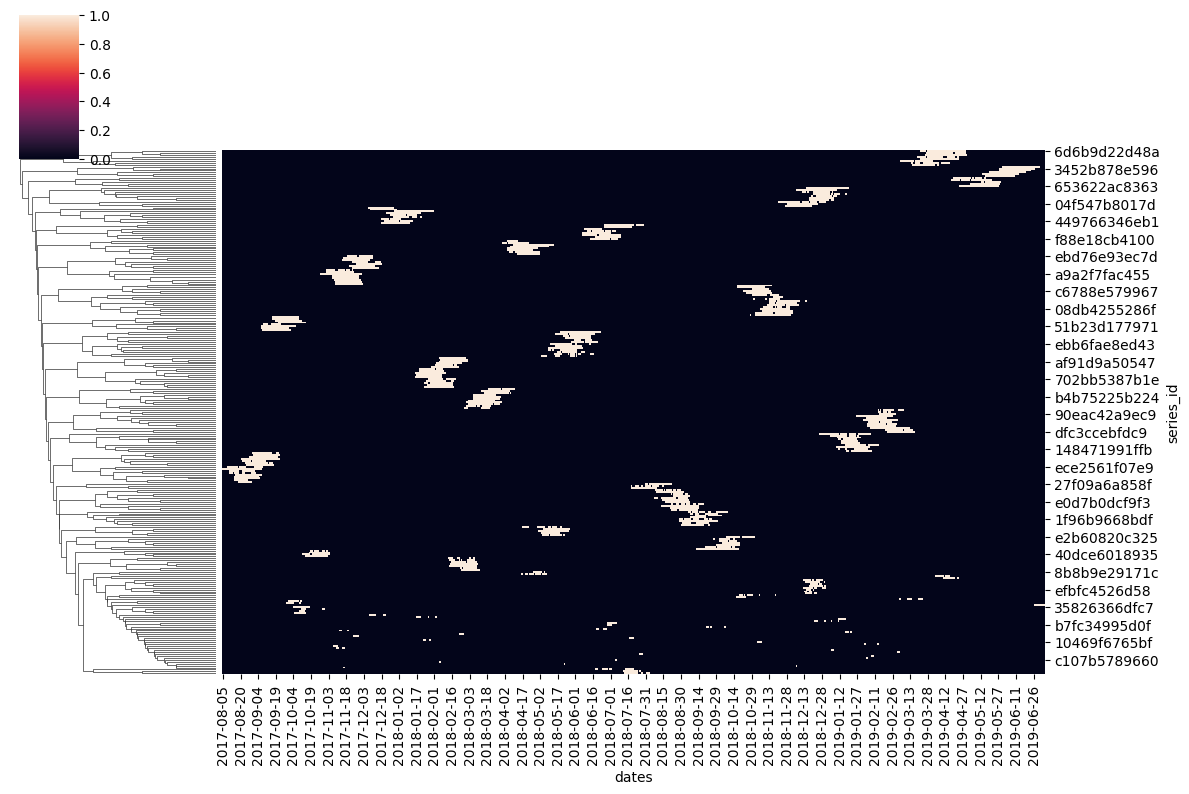

In [24]:
# Pivot the DataFrame to create df_availability
tr_ev = train_events.copy()
tr_ev['dates'] = tr_ev['timestamp'].dt.date
df_availability = tr_ev.pivot_table(columns='dates', index='series_id', values='step', aggfunc='count')

# Fill NA values with 0
df_availability = (~df_availability.isna()).fillna(0).astype('int')

# Plotting the clustered heatmap
sns.clustermap(df_availability, col_cluster=False, figsize=(12, 8))

# TODO: re-implement for plotly per
# https://stackoverflow.com/questions/66547583/plotly-clustered-heatmap-with-dendrogram-python
# https://plotly.com/python/clustergram/#default-clustergram
# https://plotly.com/python/dendrogram/

Upon examining the clustermap, it is evident that the majority of the series tend to have a duration spanning 20 to 30 days (see  also below for the night-based insights into the series durations).

The periods of time during which data have been collected are sparsely distributed across the years 2017 to 2019.

Whenever timestamps are discussed, it is essential to note the relations between 
- *steps* and *timestamps*
- impact of the sparsity of the series data on the usability of time-driven features

As per the description of the dataset, *step* is the basis for the evaluation of submitted predictions. *timestamps*, in turn, is generally used as an input for features (provided you tackle the prediction problem in the tabular classification setup).

Since the training seria samples are very sparse, it could look like that only hourly/minute trends could make some sense for the model. Trends of higher scale (daily, weekly etc.) would be misleading for the model to train in turn.

<div class="alert alert-block alert-info"> ✅ <b>Note</b>: More advanced time series insights on <i>enmo/anglez</i> are collected in a <a href="https://www.kaggle.com/code/gvyshnya/plotting-big-data-sleeping-series" target="_blank">separate notebook</a>. More specifically, it will contain the results of the clustering experiments to group series by the statistical trends displayed by <i>enmo/anglez</i> aggregated values.
</div>

In [25]:
del tr_ev, df_availability

# Returns the number of
# objects it has collected
# and deallocated
collected = gc.collect()
 
# Prints Garbage collector
# as 0 object
print("Garbage collector: collected",
          "%d objects." % collected)# Importing gc module

Garbage collector: collected 61 objects.


## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Balance Between Onset and Wakeup Events</div>

Let's now visualize the frequency of *onset* and *wakeup* events by hours in a day.

In the context, *onset* and *wakeup* events signify the times people go to sleep and wake up, respectively.

Understanding the temporal patters in manifesting these events can draw critical insights into the sleeping behavior.

In [26]:
df_onset = train_events[train_events['event'] == 'onset']
df_wakeup = train_events[train_events['event'] == 'wakeup']

fig = make_subplots(rows=1, cols=2, subplot_titles=('<b>Hourly Distr. of Onset Events</b>',
                                                    '<b>Hourly Distr. of Wakeup Events</b>',
                                                   ))

fig.add_trace(go.Histogram(x=df_onset['hour'].dropna(), nbinsx=24), row=1, col=1)
fig.add_trace(go.Histogram(x=df_wakeup['hour'].dropna(), nbinsx=24), row=1, col=2)
                                
# Update visual layout
fig.update_layout(
    showlegend=False,
    width=600,
    height=400,
    autosize=False,
    margin=dict(t=15, b=0, l=5, r=5),
    template="plotly_white",
    colorway=px.colors.qualitative.Prism ,
)

# update font size at the axes
fig.update_coloraxes(colorbar_tickfont_size=10)
# Update font in the titles: Apparently subplot titles are annotations (Subplot font size is hardcoded to 16pt · Issue #985)
fig.update_annotations(font_size=12)
# Reduce opacity
fig.update_traces(opacity=0.75)

fig.show()

In the resulting histograms, the x-axis denotes the 24-hour timeline, and the y-axis represents the frequency of *onset* and *wakeup* events.

From the charts displayed, it is evident that the majority of individuals whose sleeping series are represented in the training dataset tend to 
- wake up between 6-8 am;
- go to sleep around 8-10 pm.

Such a temporal pattern matches well with general intuition as well as provides a useful baseline for further analyses.

Let's now review the balance between the labelled *onset* and *wakeup* events in the training dataset.

In [27]:
agg_data = train_events[["event", "hour"]].groupby(["event", "hour"]).size().reset_index(name="count")
agg_data["hour"] = agg_data["hour"].astype(int)
# define figure element
fig = px.sunburst(
    agg_data,
    values='count',
    path=["event", "hour"],
    title="Events by hours in a day",
    color="event",
    height=600,
    color_discrete_sequence=px.colors.qualitative.Prism,
    #color_continuous_scale=px.colors.sequential.Viridis
)
# display the figure
fig.show()

As we can see, the number of *onset* and *wakeup* events is quite balanced in the training dataset, which indicates no labelling errors on the series where labels were generated (either fully or parcially).

However, as displayed in the sunburst chart above, the number of *wakeup* events is slightly higher then the number of *onset* events (the difference is 3 events, namely). It means the tiny fraction of the training series does have more *wakeup* events labeled than *onset* once. Let's locate the training series affected by such a mislabelling.

In [28]:
agg_data = train_events[["series_id", "event"]].groupby(["series_id", "event"]).size().reset_index(name="count")

df_wide=pd.pivot(agg_data, index=['series_id'], columns = ['event'],values = 'count') #Reshape from long to wide

#Re-arange the new columns in the correct order
cols = agg_data['event'].unique()
df_wide=df_wide[cols]
df_wide['diff'] = df_wide['wakeup'] - df_wide['onset']
df_wide.reset_index(inplace=True)
df_wide = df_wide.rename(columns = {'index':'series_id'})

df_unbalanced = df_wide[df_wide['diff'] !=0 ]

unbalanced_series = df_unbalanced['series_id'].unique()

if len(unbalanced_series) > 0:
    PrintColor(f"\n---> Displaing the ids of series where wakeups to do not equal to onset events:\n")
    pprint(unbalanced_series, indent = 10, width = 50)
else:
    PrintColor(f"\n---> No series with the unbalanced events detected")




---> No series with the unbalanced events detected


## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Event Minute Patterns</div>

Let's review the distribution of *onset/wakeup* events within the minutes of 15-min intervals (if we split the entire timeline of the training series into such 15-min intervals, it would be interesting to search for any regular pattern in the event distribution).

In [29]:
mn_train_events = pd.read_csv('/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv')
mn_train_events = mn_train_events.loc[~mn_train_events['timestamp'].isna()] # drop NA

df_onset_mn = mn_train_events[mn_train_events['event'] == 'onset']
df_wakeup_mn = mn_train_events[mn_train_events['event'] == 'wakeup']

min15_onset = df_onset_mn['timestamp'].str[-10:-8].astype('int32')%15 # minute of event, in 15 min blocks
min15_wakeup = df_wakeup_mn['timestamp'].str[-10:-8].astype('int32')%15 # minute of event, in 15 min blocks

frame1 = {'interval': min15_onset.index,
         'onset_minute': min15_onset}
 
# Creating DataFrame by passing Dictionary
agg_data_onsets = pd.DataFrame(frame1)

frame2 = {'interval': min15_wakeup.index,
         'wakeup_minute': min15_wakeup}
 
# Creating DataFrame by passing Dictionary
agg_data_wakeups = pd.DataFrame(frame2)

fig = make_subplots(rows=1, cols=2, subplot_titles=('<b>Distr. of Onset Events in 15-min intervals</b>',
                                                    '<b>Distr. of Wakeup Events in 15-min intervals</b>',
                                                   ))

fig.add_trace(go.Histogram(x=agg_data_onsets['onset_minute'].dropna(), nbinsx=24), row=1, col=1)
fig.add_trace(go.Histogram(x=agg_data_wakeups['wakeup_minute'].dropna(), nbinsx=24), row=1, col=2)
                                
# Update visual layout
fig.update_layout(
    showlegend=False,
    width=700,
    height=400,
    autosize=False,
    margin=dict(t=15, b=0, l=5, r=5),
    template="plotly_white",
    colorway=px.colors.qualitative.Prism ,
)

# update font size at the axes
fig.update_coloraxes(colorbar_tickfont_size=10)
# Update font in the titles: Apparently subplot titles are annotations (Subplot font size is hardcoded to 16pt · Issue #985)
fig.update_annotations(font_size=12)
# Reduce opacity
fig.update_traces(opacity=0.75)

fig.show()


We can observe a strange pattern in the event records, if they are looked up on 15-min intervals.

- They are always on exact minutes, maybe due to the manual classification/labelling  leading to limited precision
- They demonstrate repeatable patterns in 15 minutes cycle
- The most of events (both *onset* and *wakeup*) happen on 0th, 3rd, 7th, and 11th minutes of 15-min intervals (0 stands for the first minute of the interval, and 14 stands for the last one)
- The distribution and period of minute differ by event type, if looking at the more granular level 

Additional note for *wakeups*, we can see almost regularly equal number of events in every minute category within the 4 event frequency buckets there
- the most frequent event minutes (0, 3, 7, 11 minutes)
- second the most frequent event minutes (2, 6, 10, 14 minutes) - they stay 1 min behind the minutes in the most frequent bucket, btw
- modereate events bucket minutes (4, 8, 12 minutes)
- least frequent event bucket (1, 5, 9, 13 minutes)

It is hard to expain the rationale behind the patterns observed. Nor is it clear if it is possible to use such a discovery in the ML solutions to predict the sleeping events down the road.

<div class="alert alert-block alert-info"> ✅ <b>Note</b>: Such a strange phenomenon has been first mentioned in one of the <a href="https://www.kaggle.com/competitions/child-mind-institute-detect-sleep-states/discussion/444374" target="_blank">discussion threads</a>.</div>

As mentioned by [Daniel Dewey](https://www.kaggle.com/dan3dewey) in the comments to the above-mentioned discussion thread, the observed phenomenon indicates that
- The "ground truth" in the Events file is not exactly correct within 2 minutes or so. 
- A model that correctly identifies the real onsets/wakeups scored against this would not get an AP of 1.0, maybe a max of 0.95
- It is a function of the human rater (a person who labelled the events in the training set) and the tools they used
- The event minutes pattern is likely to follow Binomial distribution

As Daniel outliened,
<blockquote><i>
    "It's actually a classic Binomial distribution if we take n = number of events in the series and x = sum of events in 0,3,7,11 bins. Based on about 9600 events in all and 4 bins of 1450 in @ymatioun 's plot, the probability of an event being in the summed-bins is p ~ 41450/9600 ~ 0.60 (0,3,7,11-to-total ratio 0.60). The output below is from Matt Bognar's nice Binomial applet. It shows that if all the series follow this pattern then the probability of a series with 18 nights, n=36 events, having 15 or fewer (ratio 0.42 or less) in the combined 0,3,7,11 bins is unlikely, only 2 %. The evenly-distributed case would peak at about (4/15)36 ~ 9 or 10 events (ratio 0.26). So, if some series are "0,3,7,11-quantized" and some are evenly-distributed, the 0,3,7,11-to-total ratio histogram might show two peaks".
</i></blockquote>

Let's try to identify clusters of series with similar raters-tools. There aren't many events per series so comparing the number in 0, 3, 7, 11 vs the number of others could be a measure of the effect with some amount of signal to noise.

### Onset Event Patterns

Let's look at *Onset* event patterns. Initially, we are going to plot the chart to visualize relation between the number of onset events in [0,3,7,11] minute bin vs. the events in other bin.

In [30]:
def is_in_frequent_event_minute_slot(x):
    value = 0
    if x in [0,3,7,11]:
        value = 1
    return value

def is_in_other_event_minute_slot(x):
    value = 0
    if x not in [0,3,7,11]:
        value = 1
    return value

df_onset_mn['timestamp'] = pd.to_datetime(df_onset_mn['timestamp']).apply(lambda t: t.tz_localize(None))
df_onset_mn['hour'] = df_onset_mn["timestamp"].dt.hour
df_onset_mn['minute'] = df_onset_mn["timestamp"].dt.minute
df_onset_mn['15min'] = df_onset_mn['minute'] % 15

df_onset_mn['in_0_3_7_11_slot'] = df_onset_mn['15min'].apply(lambda x: is_in_frequent_event_minute_slot(x))
df_onset_mn['in_other_slot'] = df_onset_mn['15min'].apply(lambda x: is_in_other_event_minute_slot(x))

df_series_agg = df_onset_mn.groupby(['series_id'])[['in_0_3_7_11_slot', 'in_other_slot']].sum().reset_index()

fig = px.scatter(df_series_agg, x="in_0_3_7_11_slot", y="in_other_slot",
                 size='in_0_3_7_11_slot', 
                 title='Onset events in minute buckets: [0,3,7,11] vs. others',
                 color_discrete_sequence=px.colors.qualitative.Prism,
                 hover_data=['series_id'])
fig.show()

We find that 
- there is a clear separation between the series in terms of the event distribution (some series are "0,3,7,11-quantized" and some are evenly-distributed)
- the majority of series tend to have more onset events recorded in [0,3,7,11] minute bin.

Let's now calculate the ratios of events in [0,3,7,11] minute bin and in other bin for each series as well as plot the histograms of them.

In [31]:
df_series_agg['ratio_0_3_7_11'] = df_series_agg['in_0_3_7_11_slot'] / (df_series_agg['in_0_3_7_11_slot'] + df_series_agg['in_other_slot'])
df_series_agg['ratio_other'] = 1 - df_series_agg['ratio_0_3_7_11']

fig = make_subplots(rows=1, cols=2, subplot_titles=('<b>Distr. of Onsets ratio in [0,3,7,11] minute bucket</b>',
                                                    '<b>Distr. of Onsets ratio in other minute bucket</b>',
                                                   ))

fig.add_trace(go.Histogram(x=df_series_agg['ratio_0_3_7_11'].dropna(), nbinsx=24), row=1, col=1)
fig.add_trace(go.Histogram(x=df_series_agg['ratio_other'].dropna(), nbinsx=24), row=1, col=2)
                                
# Update visual layout
fig.update_layout(
    showlegend=False,
    width=800,
    height=400,
    autosize=False,
    margin=dict(t=15, b=0, l=5, r=5),
    template="plotly_white",
    colorway=px.colors.qualitative.Prism ,
)

# update font size at the axes
fig.update_coloraxes(colorbar_tickfont_size=10)
# Update font in the titles: Apparently subplot titles are annotations (Subplot font size is hardcoded to 16pt · Issue #985)
fig.update_annotations(font_size=12)
# Reduce opacity
fig.update_traces(opacity=0.75)

fig.show()


We find that
- there are two closely located peaks at 0.525-05749 and 0.625-06749, respectively; so, we can conclude it fits into the binomial distribution
- there is a large cluster of series in terms of the spread of `ratio_0_3_7_11` values (between 0.525 and 0.6749, 114 out of 277 series inclusive) 
- the overall distribution of `ratio_0_3_7_11` is skewed to the right, indicating more series to have events recorded in the *[0,3,7,11]* minute bin

### Wakeup Event Patterns

Let's look at *Wakeup* event patterns now. Initially, we are going to plot the chart to visualize relation between the number of wakeup events in [0,3,7,11] minute bin vs. the events in other bin.

In [32]:
df_wakeup_mn['timestamp'] = pd.to_datetime(df_wakeup_mn['timestamp']).apply(lambda t: t.tz_localize(None))
df_wakeup_mn['hour'] = df_wakeup_mn["timestamp"].dt.hour
df_wakeup_mn['minute'] = df_wakeup_mn["timestamp"].dt.minute
df_wakeup_mn['15min'] = df_wakeup_mn['minute'] % 15

df_wakeup_mn['in_0_3_7_11_slot'] = df_wakeup_mn['15min'].apply(lambda x: is_in_frequent_event_minute_slot(x))
df_wakeup_mn['in_other_slot'] = df_wakeup_mn['15min'].apply(lambda x: is_in_other_event_minute_slot(x))

df_series_agg = df_wakeup_mn.groupby(['series_id'])[['in_0_3_7_11_slot', 'in_other_slot']].sum().reset_index()

fig = px.scatter(df_series_agg, x="in_0_3_7_11_slot", y="in_other_slot",
                 size='in_0_3_7_11_slot', 
                 title='Wakeup events in minute buckets: [0,3,7,11] vs. others',
                 color_discrete_sequence=px.colors.qualitative.Prism,
                 hover_data=['series_id'])
fig.show()

We find that 
- there is a clear separation between the series in terms of the event distribution (some series are "0,3,7,11-quantized" and some are evenly-distributed)
- the majority of series tend to have more wakeup events recorded in [0,3,7,11] minute bin.

Let's now calculate the ratios of events in [0,3,7,11] minute bin and in other bin for each series as well as plot the histograms of them.

In [33]:
df_series_agg['ratio_0_3_7_11'] = df_series_agg['in_0_3_7_11_slot'] / (df_series_agg['in_0_3_7_11_slot'] + df_series_agg['in_other_slot'])
df_series_agg['ratio_other'] = 1 - df_series_agg['ratio_0_3_7_11']

fig = make_subplots(rows=1, cols=2, subplot_titles=('<b>Distr. of Wakeups ratio in [0,3,7,11] minute bucket</b>',
                                                    '<b>Distr. of Wakeups ratio in other minute bucket</b>',
                                                   ))

fig.add_trace(go.Histogram(x=df_series_agg['ratio_0_3_7_11'].dropna(), nbinsx=24), row=1, col=1)
fig.add_trace(go.Histogram(x=df_series_agg['ratio_other'].dropna(), nbinsx=24), row=1, col=2)
                                
# Update visual layout
fig.update_layout(
    showlegend=False,
    width=800,
    height=400,
    autosize=False,
    margin=dict(t=15, b=0, l=5, r=5),
    template="plotly_white",
    colorway=px.colors.qualitative.Prism ,
)

# update font size at the axes
fig.update_coloraxes(colorbar_tickfont_size=10)
# Update font in the titles: Apparently subplot titles are annotations (Subplot font size is hardcoded to 16pt · Issue #985)
fig.update_annotations(font_size=12)
# Reduce opacity
fig.update_traces(opacity=0.75)

fig.show()


We find that
- there are two peaks at 0.625-06749 and 0.975-1, respectively; so, we can conclude it fits into the binomial distribution
- there is a large cluster of series in terms of the spread of `ratio_0_3_7_11` values (between 0.525 and 0.8249, 171 out of 277 series inclusive) 
- the overall distribution of `ratio_0_3_7_11` is skewed to the right, indicating more series to have events recorded in the *[0,3,7,11]* minute bin

In [34]:
del mn_train_events, df_onset_mn, df_wakeup_mn, agg_data_onsets, agg_data_wakeups, df_series_agg, frame1, frame2

# Returns the number of
# objects it has collected
# and deallocated
collected = gc.collect()
 
# Prints Garbage collector
# as 0 object
print("Garbage collector: collected",
          "%d objects." % collected)# Importing gc module

Garbage collector: collected 5571 objects.


## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Sleep Duration</div>

Let's review how many hours the people observed in the training set sleep in average.

In [35]:
# inspired by https://www.kaggle.com/code/alinasri/sleep-data-analysis-some-eda

# Lets focus on non null rows of the training events only
mask_nonull= (~train_events['step'].isnull()) & (~train_events['timestamp'].isnull()) 
train_events_nonull = train_events[mask_nonull]

# Group by 'series_id' and calculate sleep duration for each night
sleep_duration_df = train_events_nonull.groupby([train_events_nonull['series_id'], train_events_nonull['night']])['timestamp'].agg(['min', 'max']).reset_index()
sleep_duration_df = sleep_duration_df.rename(columns={'min': 'onset', 'max': 'wakeup'})
sleep_duration_df['sleep_duration'] = ((sleep_duration_df['wakeup'] - sleep_duration_df['onset']).dt.seconds / 3600).round(0)

dfg = sleep_duration_df['sleep_duration'].value_counts().reset_index()
dfg.columns = ['sleep_duration', 'number_of_observations']
fig = px.bar(dfg, x='sleep_duration', y='number_of_observations', 
             title='Sleep Duration, Training seria (hours)',
            color_discrete_sequence=px.colors.qualitative.Prism) 
fig.show()

We can see that the most of the training observations (within the series-to-nights dimensions) demonstrated the sleep duration to be between 8 and 10 h per night (day), with the sleeping time of 9 h per day to be the most frequent value. 

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Nights Data Insights</div>

In [36]:
nights_in_series = train_events.groupby('series_id')['night'].max()

frame = {'series_id': nights_in_series.index,
         'number_of_nights_in_seria': nights_in_series}
 
# Creating DataFrame by passing Dictionary
agg_data = pd.DataFrame(frame)

fig = px.histogram(agg_data, x="number_of_nights_in_seria", marginal="rug",
                   title='Distribution of Nights per Series in Training Events',
                   color_discrete_sequence=px.colors.qualitative.Prism)
fig.show()

We find that

- the majority of the series has *20-29* nights in it
- the second 'cluster' contains the series with *30-39* nights in it
- the tails of the distribution are minor; 
- we can indicate there are exceptionally long ('outlier') series with *84* and *62* nights, respectively

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Steps Data Insights</div>

In [37]:
min_steps_in_series = train_series.groupby('series_id')['step'].min()
max_steps_in_series = train_series.groupby('series_id')['step'].max()

frame1 = {'series_id': min_steps_in_series.index,
         'min_number_of_steps_in_seria': min_steps_in_series}

frame2 = {'series_id': max_steps_in_series.index,
         'max_number_of_steps_in_seria': max_steps_in_series}
 
# Creating DataFrames by passing Dictionary
min_steps_df = pd.DataFrame(frame1)
max_steps_df = pd.DataFrame(frame2)

min_steps_df.reset_index(drop = True, inplace = True)
max_steps_df.reset_index(drop = True, inplace = True)

agg_data = pd.merge(min_steps_df, max_steps_df, how='inner', on=['series_id'])
agg_data['steps_number'] = agg_data['max_number_of_steps_in_seria'] - agg_data['min_number_of_steps_in_seria']

fig = px.histogram(agg_data, x="steps_number", marginal="rug",
                   title='Distribution of Steps per Series in Training Series',
                   color_discrete_sequence=px.colors.qualitative.Prism)
fig.show()

We can see that the distribution of steps follows the general distributions by nights, more or less. Every step corresponds to one instance of the accelerometer measurements that are recorded every 5 s (if no errors/breaks happen).

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Timestamp-Related Insights</div>

In this chapter, we are going to investigate several time-related issues as follows

- Shall we keep the events and *enmo/anglez* series timestamps in local time zone time or in UTC?
- What could be the effect of daylight time saving shifts on the series data?

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">To UTC or not to UTC?</div>

Since the timestamps in both the series and events data are presented with the local time zone offsets, the real question is whether it makes sense to keep the event time in the local time zones or cast them all to UTC. This section is going to visualize some TZ-related patterns.  

<div class="alert alert-block alert-info"> ✅ <b>Note</b>: It was Carl McBride Ellis who first paid attention to the UTC vs. local time zone issues. He put together <a href="https://www.kaggle.com/code/carlmcbrideellis/zzzs-eda-utc-or-not-utc" target="_blank">a quick notebook</a> to spot the problem. We are going to elevate it to the next level by visualizing the patterns.
</div>

In [38]:
ground_truth = pd.read_csv("/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv")

# get event counts in UTC
df = ground_truth.copy()
df["timestamp"] = pd.to_datetime(df["timestamp"],utc=True)
df["hour"] = df["timestamp"].dt.hour
# filter for mornings and afternons
df_morning   = df.loc[df["hour"] <= 12].copy()
df_afternoon = df.loc[df["hour"]  > 12].copy()

utc_stat = {
    "label": "UTC",
    "morning_wakeups": df_morning.loc[df_morning["event"] == "wakeup"].shape[0],
    "morning_onsets": df_morning.loc[df_morning["event"] == "onset"].shape[0],
    "afternoon_onsets": df_afternoon.loc[df_afternoon["event"] == "onset"].shape[0],
    "afternoon_wakeups": df_afternoon.loc[df_afternoon["event"] == "wakeup"].shape[0]
}

# get event counts in the local time zone time
df = ground_truth.copy()
df['timestamp'] = pd.to_datetime(df['timestamp']).apply(lambda t: t.tz_localize(None))
df["hour"] = df["timestamp"].dt.hour
# filter for mornings and afternons
df_morning   = df.loc[df["hour"] <= 12].copy()
df_afternoon = df.loc[df["hour"]  > 12].copy()

local_tz_stat = {
    "label": "Local time",
    "morning_wakeups": df_morning.loc[df_morning["event"] == "wakeup"].shape[0],
    "morning_onsets": df_morning.loc[df_morning["event"] == "onset"].shape[0],
    "afternoon_onsets": df_afternoon.loc[df_afternoon["event"] == "onset"].shape[0],
    "afternoon_wakeups": df_afternoon.loc[df_afternoon["event"] == "wakeup"].shape[0]
}

data = [utc_stat, local_tz_stat]
df_stat = pd.DataFrame.from_dict(data)

fig = make_subplots(rows=2, cols=2, subplot_titles=('<b>Morning Wakeups: UTC vs. Local time</b>',
                                                    '<b>Morning Onsets: UTC vs. Local time</b>',
                                                    '<b>Afternoon Onsets: UTC vs. Local time</b>',
                                                    '<b>Afternoon Wakeups: UTC vs. Local time</b>'
                                                   ))

fig.add_trace(go.Bar(x=df_stat['label'], y=df_stat['morning_wakeups']), row=1, col=1)
fig.add_trace(go.Bar(x=df_stat['label'], y=df_stat['morning_onsets']), row=1, col=2)
fig.add_trace(go.Bar(x=df_stat['label'], y=df_stat['afternoon_onsets']), row=2, col=1)
fig.add_trace(go.Bar(x=df_stat['label'], y=df_stat['afternoon_wakeups']), row=2, col=2)
                                
# Update visual layout
fig.update_layout(
    showlegend=False,
    width=600,
    height=400,
    autosize=False,
    margin=dict(t=15, b=0, l=5, r=5),
    template="plotly_white",
    colorway=px.colors.qualitative.Prism ,
)

# update font size at the axes
fig.update_coloraxes(colorbar_tickfont_size=10)
# Update font in the titles: Apparently subplot titles are annotations (Subplot font size is hardcoded to 16pt · Issue #985)
fig.update_annotations(font_size=12)
# Reduce opacity
fig.update_traces(opacity=0.75)

fig.show()

We can see that operating the events / series timestamps in the local time makes more sense from the logical standpoint as the number of wakeup/onset events in the morning and afternoon looks more intuitive.

<div class="alert alert-block alert-warning"> 🚩 <b>Note</b>: Using the timestamps in UTC vs. the local time zone's time makes a difference when it comes to the visualizations and other EDA activities. However, using either UTC or local time stamps does not make a big difference for ML models to be trained. There is a DST change date-related glitch in the raw training series data provided by the contest host. Its assessment, along with the impact on the data loading strategies and workarounds, is extensively covered in a <a href="https://www.kaggle.com/code/gvyshnya/sleeping-series-integrity-check/" target="_blank">separate notebook of mine</a>.</div>

In [39]:
del ground_truth, df, df_morning, df_afternoon, df_stat


# Returns the number of
# objects it has collected
# and deallocated
collected = gc.collect()
 
# Prints Garbage collector
# as 0 object
print("Garbage collector: collected",
          "%d objects." % collected)# Importing gc module

Garbage collector: collected 2599 objects.


# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Deep Dive into Series Data</div>

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Initial Data Inspection</div>

Let's look at the series data both in the training and testing sets. Before jumping deeply inside the series insights, let's shrink the training series data to only contain 37 series fully covered with the labelled events data.

In [40]:
%%time
train_series = train_series[train_series['series_id'].isin(no_NaN_series)]

CPU times: user 5.79 s, sys: 318 ms, total: 6.11 s
Wall time: 6.06 s


In [41]:
summarize_dataframe(train_series).style.background_gradient(cmap='Purples')

,dtypes,missing#,missing%,uniques,count,min,max,mean
series_id,object,0,0.000000,37,14334840,nan,nan,nan
step,float32,0,0.000000,634680,14334840,0.000000,634679.000000,210655.640625
timestamp,datetime64[ns],0,0.000000,7231140,14334840,2017-08-15 16:45:00,2019-07-05 09:14:55,2018-03-06 09:31:23.264321280
anglez,float16,0,0.000000,21765,14334840,-90.000000,90.000000,nan
enmo,float16,0,0.000000,6383,14334840,0.000000,7.015625,nan
year,int16,0,0.000000,3,14334840,2017.000000,2019.000000,2017.549474
month,float16,0,0.000000,12,14334840,1.000000,12.000000,nan
day,float16,0,0.000000,31,14334840,1.000000,31.000000,nan
hour,float16,0,0.000000,24,14334840,0.000000,23.000000,nan


In [42]:
summarize_dataframe(test_series).style.background_gradient(cmap='Purples')

,dtypes,missing#,missing%,uniques,count,min,max,mean
series_id,object,0,0.000000,3,450,nan,nan,nan
step,float16,0,0.000000,150,450,0.000000,149.000000,74.500000
timestamp,datetime64[ns],0,0.000000,450,450,2018-05-31 12:00:00,2018-12-18 12:57:25,2018-08-31 13:31:12.500000
anglez,float16,0,0.000000,186,450,-88.375000,68.437500,-56.187500
enmo,float16,0,0.000000,183,450,0.000000,0.979980,0.030273
year,int16,0,0.000000,1,450,2018.000000,2018.000000,2018.000000
month,float16,0,0.000000,3,450,5.000000,12.000000,8.335938
day,float16,0,0.000000,3,450,14.000000,31.000000,21.000000
hour,float16,0,0.000000,2,450,12.000000,15.000000,12.992188



We find that
- the series data in the shrinked training set contains the information for *37* series
- the  series data in the testing set contains the  information for *3* series to be used for prediction
- we can note statistically significant differences in the spread of *angelz* and *enmo* in the training and testing series

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Dailight Saving Time Impact on Traing Series</div>

This section will draw intelligence on how the training series are affected by DST change dates.

Since the competion host (Child Mind Insitute) is located in New York, USA, its patient sleep records are provided on East time (East Cost, USA).

This area is affected by Dailight Saving Time (DST) changes twice a year. Its timezone is either -0400 (EST) or -0500 (EDT), depending on daylight saving.

### USA Daylight Change Dates

<div class="article-body"><p>On August 8, 2005, the Energy Policy Act of 2005 was signed into law, which extended Daylight Saving Time (DST) in the United States by approximately four weeks. As a result, beginning in 2007, Daylight Saving Time starts three weeks earlier on the second Sunday in March and ends one week later on the first Sunday of November, resulting in a new Daylight Saving Time period that is four weeks longer than previously observed.</p>
<ul>
<li>In the Spring, turn clocks forward one hour on the second Sunday in March.</li>
<li>In the Fall, turn clocks backward one hour on the first Sunday in November.</li>
</ul>
<p>Daylight Saving Time dates are listed specifically by year, as per the table below.</p>
<table>
<tbody>
<tr>
<th>Year</th>
<th>DST Begins</th>
<th>DST Ends</th>
<th>Year</th>
<th>DST Begins</th>
<th>DST Ends</th>
</tr>
<tr>
<td>2014</td>
<td>March 9</td>
<td>November 2</td>
<td>2024</td>
<td>March 10</td>
<td>November 3</td>
</tr>
<tr>
<td>2015</td>
<td>March 8</td>
<td>November 1</td>
<td>2025</td>
<td>March 9</td>
<td>November 2</td>
</tr>
<tr>
<td>2016</td>
<td>March 13</td>
<td>November 6</td>
<td>2026</td>
<td>March 8</td>
<td>November 1</td>
</tr>
<tr>
<td>2017</td>
<td>March 12</td>
<td>November 5</td>
<td>2027</td>
<td>March 14</td>
<td>November 7</td>
</tr>
<tr>
<td>2018</td>
<td>March 11</td>
<td>November 4</td>
<td>2028</td>
<td>March 12</td>
<td>November 5</td>
</tr>
<tr>
<td>2019</td>
<td>March 10</td>
<td>November 3</td>
<td>2029</td>
<td>March 11</td>
<td>November 4</td>
</tr>
<tr>
<td>2020</td>
<td>March 8</td>
<td>November 1</td>
<td>2030</td>
<td>March 10</td>
<td>November 3</td>
</tr>
<tr>
<td>2021</td>
<td>March 14</td>
<td>November 7</td>
<td>2031</td>
<td>March 9</td>
<td>November 2</td>
</tr>
<tr>
<td>2022</td>
<td>March 13</td>
<td>November 6</td>
<td>2032</td>
<td>March 14</td>
<td>November 7</td>
</tr>
<tr>
<td>2023</td>
<td>March 12</td>
<td>November 5</td>
<td>2033</td>
<td>March 13</td>
<td>November 6</td>
</tr>
</tbody>
</table>
<p> </p>
<p> </p></div>

<div class="alert alert-block alert-info"> ✅ <b>Note</b>:The information above is cited based on the respective <a href="https://kb.lathem.com/hc/en-us/articles/115005029348-Daylight-Saving-Time-Starting-And-Ending-Dates" target="_blank">Knowledge Base article</a>.</div>

In [ ]:
!pip install duckdb --quiet

In [ ]:
import duckdb

parquet_table = '/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet'
testing_parquet_table = '/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet'
training_events_table = '/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv'

con = duckdb.connect()

In [ ]:
con.execute(f"""
    CREATE TABLE train_series AS
    SELECT * 
    FROM read_parquet('{parquet_table}');
""")

In [ ]:
con.execute(f"""
    CREATE TABLE test_series AS
    SELECT * 
    FROM read_parquet('{testing_parquet_table}');
""")

In [ ]:
# we intentionally load every col as VARCHAR; we need to load timestamp as a varchar, to prevent the UTC time casting at load
con.execute(f"""
    CREATE TABLE train_events AS
    SELECT * 
    FROM read_csv('{training_events_table}', ALL_VARCHAR=1, AUTO_DETECT=TRUE);
""")

In [ ]:
# inspired by 
# - https://www.kaggle.com/code/mitsuyasuhoshino/cmi-detectsleepstates-eda-visualization
# - https://www.kaggle.com/code/carlmcbrideellis/zzzs-eda-utc-or-not-utc
def get_series_data_with_events(series_id):
    
    train_series_sql = f"""
        SELECT
        series_id,
        CAST (step AS INTEGER) AS step,
        timestamp,
        CAST (anglez AS FLOAT) AS anglez,
        CAST (enmo AS FLOAT) AS enmo
        FROM train_series WHERE series_id = '{series_id}'
    """
    df = con.execute(train_series_sql).fetchdf()
    
    #df['date_time'] = pd.to_datetime(df['timestamp'], utc=True)
    df['date_time'] = pd.to_datetime(df['timestamp']).apply(lambda t: t.tz_localize(None))
    df = df.drop('timestamp', axis=1)
    
    train_events_sql = f"""
        SELECT 
            series_id,
            CAST (night as INTEGER) as night,
            event,
            CAST (step as INTEGER) as step,
            timestamp
        FROM train_events 
        WHERE series_id = '{series_id}'
    """
    
    ev = con.execute(train_events_sql).fetchdf()
    #ev['date_time'] = pd.to_datetime(ev['timestamp'], utc=True)
    ev['date_time'] = pd.to_datetime(ev['timestamp']).apply(lambda t: t.tz_localize(None))
    ev = ev.drop('timestamp', axis=1)
    
    df2 = pd.merge(df, ev, on='date_time', how='outer')
    df2 = df2.drop(['series_id_x','series_id_y','step_x','step_y'], axis=1)
    df2['event'] = df2['event'].fillna(0)
    
    # fill values for night feature
    df2['night'][0] = 1
    df2['night'] = df2['night'].interpolate()
    df2['night'] = round(df2['night'])
    # map numeric values to event feature
    df2.loc[df2['event']=='onset','event'] = -1
    df2.loc[df2['event']=='wakeup','event'] = 1
    
    return df2

def get_train_series_data(series_id):
    train_series_sql = f"""
        SELECT
        series_id,
        CAST (step AS INTEGER) AS step,
        timestamp,
        CAST (anglez AS FLOAT) AS anglez,
        CAST (enmo AS FLOAT) AS enmo
        FROM train_series WHERE series_id = '{series_id}'
    """
    train_df = con.execute(train_series_sql).fetchdf()
    return train_df

def get_test_series_data(series_id):
    test_series_sql = f"""
        SELECT
        series_id,
        CAST (step AS INTEGER) AS step,
        timestamp,
        CAST (anglez AS FLOAT) AS anglez,
        CAST (enmo AS FLOAT) AS enmo
        FROM test_series WHERE series_id = '{series_id}'
    """
    df = con.execute(test_series_sql).fetchdf()
    
    return df


### Checking Training Series Boundaries

Since the training series data spreads on 2017-2019 sparsly, we need to check which series overlap with the dailight saving events.

In [ ]:
def get_train_series_date_boundaries():
    sql = f"""
        WITH start_end AS (
            SELECT
            series_id,
            MIN (timestamp) as series_start,
            MAX (timestamp) as series_end
            FROM train_series
        GROUP BY 1
        ),
        over_dst_start AS (
            SELECT DISTINCT
                series_id,
                '1' AS is_over_dst_start
                FROM train_series
                WHERE 
                timestamp LIKE '2017-03-12%' OR
                timestamp LIKE '2018-03-11%' OR
                timestamp LIKE '2019-03-10%'
        ),
        over_dst_end AS (
            SELECT DISTINCT
                series_id,
                '1' AS is_over_dst_end
                FROM train_series
                WHERE 
                timestamp LIKE '2017-11-05%' OR
                timestamp LIKE '2018-11-04%' OR
                timestamp LIKE '2019-11-03%'
        )
        SELECT
            start_end.series_id,
            start_end.series_start,
            start_end.series_end,
            over_dst_start.is_over_dst_start,
            over_dst_end.is_over_dst_end
            FROM start_end
            LEFT JOIN over_dst_start ON
                (over_dst_start.series_id = start_end.series_id)
            LEFT JOIN over_dst_end ON
                (over_dst_end.series_id = start_end.series_id);
        
    """
    df = con.execute(sql).fetchdf()
    
    return df

Let's review the start and end timestamps of each of the training series as well as check if any of DST start/end dates for *2017-2019* falls into them.

First of all, we are going to load train series data (start of their timestamps interval, end of their timestamps interval, and a set of binary *0/1* variables to indicate how each series is affected by DTS).

In [ ]:
train_series_data = get_train_series_date_boundaries()
train_series_data = train_series_data.fillna('0')
train_series_data['is_over_dst_start'] = train_series_data['is_over_dst_start'].astype(int)
train_series_data['is_over_dst_end'] = train_series_data['is_over_dst_end'].astype(int)

def sum_row(x):
    return x['is_over_dst_start'] + x['is_over_dst_end']

train_series_data['affected_by_dst'] = train_series_data.apply(sum_row, axis=1)
train_series_data.head(10)

### DST Change Effects on Training Series Data

Let's check if any series goes through either the beginning and/or the end of DST period.

In [ ]:
dst_df = train_series_data[ train_series_data['affected_by_dst'] > 1]

msg = f"Number of training series going through both the DST start and DST end dates: {dst_df.shape[0]}"
PrintColor(f"\n---> {msg}")
if dst_df.shape[0] == 0:
    PrintColor(f"\n---> As we can see, none of the training series is long enough to go through both thee DST start and DST end dates of the same year.")

Now, let's visualize the distribution of series that are

- affeced by DTS change start
- affected by DTS change end
- not affected by DTS change

In [ ]:
summmary_stat = {
    'series_with': ["DST start date", "DST end date", "None of DST dates"],
    'series_count': [
        train_series_data['is_over_dst_start'].sum(),
        train_series_data['is_over_dst_end'].sum(),
        train_series_data.shape[0] - train_series_data['is_over_dst_start'].sum() - train_series_data['is_over_dst_end'].sum()
    ]
}
summary_df = pd.DataFrame(summmary_stat)
fig = px.bar(summary_df, x='series_with', y='series_count', 
             title='Number of series overlapping with any of DST dates',
            color_discrete_sequence=px.colors.qualitative.Prism) 
fig.show()

We can see that

- the majority of the series in the training dataset (`234`) are not affected by DST change
- `22` series overlap with DST change start dates
- `21` series overlap with DST change end dates
- none of the training series lasts through both DST change start and end dates

<div class="alert alert-block alert-warning"> 🚩 <b>Note</b>: There is a DST change date-related glitch in the raw training series data provided by the contest host. Its assessment, along with the impact on the data loading strategies and workarounds, is extensively covered in a <a href="https://www.kaggle.com/code/gvyshnya/sleeping-series-integrity-check/" target="_blank">separate notebook of mine</a>.</div>

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Series Start and End: Minute patterns</div>

Let's look at the series start minutes.

In [ ]:
def get_train_series_date_intervals():
    sql = f"""
        SELECT
            series_id,
            MIN (timestamp) as series_start,
            MAX (timestamp) as series_end
            FROM train_series
        GROUP BY 1
    """
    df = con.execute(sql).fetchdf()
    
    return df

df_train_series = get_train_series_date_intervals()

df_train_series['series_start'] = pd.to_datetime(df_train_series['series_start']).apply(lambda t: t.tz_localize(None))
df_train_series['series_end'] = pd.to_datetime(df_train_series['series_end']).apply(lambda t: t.tz_localize(None))
df_train_series['start_minute'] = df_train_series["series_start"].dt.minute
df_train_series['end_minute'] = df_train_series["series_end"].dt.minute

In [ ]:
dfg = df_train_series['start_minute'].value_counts().reset_index()
dfg.columns = ['start_minute', 'number_of_series']
fig = px.bar(dfg, x='start_minute', y='number_of_series', 
             title='Training Series: Start minutes',
            color_discrete_sequence=px.colors.qualitative.Prism) 
fig.show()

Now, let's look at the series end minutes.

In [ ]:
dfg = df_train_series['end_minute'].value_counts().reset_index()
dfg.columns = ['end_minute', 'number_of_series']
fig = px.bar(dfg, x='end_minute', y='number_of_series', 
             title='Training Series: End minutes',
            color_discrete_sequence=px.colors.qualitative.Prism) 
fig.show()

As we review the diagrams above, we can see the clear patterns as for
- the training series to start exactly in one of the four minute slots (that is, either in 0th, 15th, 30th, or 45th minute of an hour)
- the training series to end exactly in ne of the four minute slots (that is, either in 14th, 29th, 44th, or 59th minute of an hour)

Such a 15-min step in the series start/finish is probably the artifact to the measuring system at the competition host end as well as the artifact to the method of shrinking the series data for the purpose of formating the training set of this competition.

<div class="alert alert-block alert-info"> ✅ <b>Note</b>: Such a pattern extends the set of phenomena related to the methods of the data collection/preparation on the contest host side. Earlier, we have been discussing the event minute pattern.</div>

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Data Analytics: enmo (training series)</div>

In [ ]:
def get_all_series_boxplot_data(table, col_name, where_clause = None):
    min_max_sql = ""
    quantile_sql = ""
    if where_clause:
        min_max_sql = f"""
            SELECT series_id, 
            MIN({col_name}) AS min_value, 
            AVG({col_name}) AS mean_value, 
            MAX({col_name}) AS max_value,
            stddev_pop({col_name}) AS stddev
            FROM {table}
            GROUP BY series_id
            WHERE {where_clause}
        """
        quantile_sql = f"""
            WITH stats as (
              SELECT
                series_id,
                percentile_disc([0.25, 0.50, 0.75]) WITHIN GROUP 
                  (ORDER BY {col_name}) AS percentiles
              FROM {table}
              GROUP BY series_id
              WHERE {where_clause}
            )
            SELECT
              series_id,
              percentiles[1] as q1,
              percentiles[2] as median,
              percentiles[3] as q3
            FROM stats;
        """
    else:
        min_max_sql = f"""
            SELECT series_id, 
            MIN({col_name}) AS min_value, 
            AVG({col_name}) AS mean_value, 
            MAX({col_name}) AS max_value,
            stddev_pop({col_name}) AS stddev
            FROM {table}
            GROUP BY series_id
        """
        quantile_sql = f"""
            WITH stats as (
              SELECT
                series_id,
                percentile_disc([0.25, 0.50, 0.75]) WITHIN GROUP 
                  (ORDER BY {col_name}) AS percentiles
              FROM {table}
              GROUP BY series_id
            )
            SELECT
              series_id,
              percentiles[1] as q1,
              percentiles[2] as median,
              percentiles[3] as q3
            FROM stats;
        """
    df_mean_max = con.execute(min_max_sql).fetchdf()
    df_quantile = con.execute(quantile_sql).fetchdf()
    
    df = pd.merge(
        df_mean_max,
        df_quantile,
        how="inner",
        on='series_id')
    
    #rearrange the order of cols to make it a canonical boxplot style
    df = df[['series_id', 'min_value', 'q1', 'median', 'q3', 'max_value', 'mean_value', 'stddev']]
    
    return df


In [ ]:
def get_boxplot_data(table, col_name, where_clause = None):
    min_max_sql = ""
    quantile_sql = ""
    if where_clause:
        min_max_sql = f"""
            SELECT '{col_name}' AS attribute, 
            MIN({col_name}) AS min_value, 
            AVG({col_name}) AS mean_value, 
            MAX({col_name}) AS max_value,
            stddev_pop({col_name}) AS stddev
            FROM {table}
            WHERE {where_clause}
        """
        quantile_sql = f"""
            WITH stats as (
              SELECT
                percentile_disc([0.25, 0.50, 0.75]) WITHIN GROUP 
                  (ORDER BY {col_name}) AS percentiles
              FROM {table}
              WHERE {where_clause}
            )
            SELECT
              '{col_name}' AS attribute,
              percentiles[1] as q1,
              percentiles[2] as median,
              percentiles[3] as q3
            FROM stats;
        """
    else:
        min_max_sql = f"""
            SELECT '{col_name}' AS attribute, 
            MIN({col_name}) AS min_value, 
            AVG({col_name}) AS mean_value, 
            MAX({col_name}) AS max_value,
            stddev_pop({col_name}) AS stddev
            FROM {table}
        """
        quantile_sql = f"""
            WITH stats as (
              SELECT
                percentile_disc([0.25, 0.50, 0.75]) WITHIN GROUP 
                  (ORDER BY {col_name}) AS percentiles
              FROM {table}
            )
            SELECT
              '{col_name}' AS attribute,
              percentiles[1] as q1,
              percentiles[2] as median,
              percentiles[3] as q3
            FROM stats;
        """
    df_mean_max = con.execute(min_max_sql).fetchdf()
    df_quantile = con.execute(quantile_sql).fetchdf()
    
    df = pd.merge(
        df_mean_max,
        df_quantile,
        how="inner",
        on='attribute')
    
    #rearrange the order of cols to make it a canonical boxplot style
    df = df[['attribute', 'min_value', 'q1', 'median', 'q3', 'max_value', 'mean_value', 'stddev']]
    
    return df

def build_boxplot(table, col_name, where_clause = None):
    df = get_boxplot_data(table, col_name, where_clause)
    fig_title = ""
    
    bar_name = "".join([table, ".", col_name])
    
    if where_clause:
        fig_title = "".join([table, ".", col_name, ": ", where_clause])
    else:
        fig_title = "".join([table, ".", col_name, ": Entire table population"])
    
    fig = go.Figure()

    fig.add_trace(go.Box(
        y= [ df['min_value'].iloc[0], df['max_value'].iloc[0] ],
        name=bar_name, boxpoints=False,)
      )

    fig.update_traces(q1=[ df['q1'].iloc[0] ], median=[ df['median'].iloc[0] ],
                  q3=[ df['q3'].iloc[0] ], lowerfence=[df['min_value'].iloc[0]],
                  upperfence=[df['max_value'].iloc[0]], mean=[ df['mean_value'].iloc[0] ],
                  sd=[ df['stddev'].iloc[0]]
                 )
    # Update visual layout
    fig.update_layout(
        showlegend=False,
        width=600,
        height=400,
        autosize=False,
        margin=dict(t=15, b=0, l=5, r=5),
        title=dict(text=fig_title, font=dict(size=16), automargin=True, yref='paper'),
        title_x=0.5, # center the title
        template="plotly_white",
        colorway=px.colors.qualitative.Prism ,
    )
    
    # update font size at the axes
    fig.update_coloraxes(colorbar_tickfont_size=10)
    # Update font in the titles: Apparently subplot titles are annotations (Subplot font size is hardcoded to 16pt · Issue #985)
    fig.update_annotations(font_size=12)
    # Reduce opacity
    fig.update_traces(opacity=0.75)
    
    return fig


In [ ]:
# https://duckdb.org/docs/sql/aggregates
def get_histogram_data(table, col_name, where_clause = None):
    query = ""
    if where_clause:
        query = f"""
            SELECT histogram({col_name}) FROM {table}
            WHERE {where_clause};
        """
    else:
        query = f"""
            SELECT histogram({col_name}) FROM {table};
        """
    df = con.execute(query).fetchdf()
    
    hist_col_name = f"histogram({col_name})"

    histogram_dict = df[hist_col_name].iloc[0] # dictionary: dict_keys(['key', 'value'])

    frame = {
        col_name: histogram_dict.get('key'),
        'record_count': histogram_dict.get('value')}
 
    # Creating DataFrame by passing Dictionary
    agg_data = pd.DataFrame(frame)
    return agg_data
    
def build_histogram(table, col_name, where_clause = None):
    figure_title = ""
    if where_clause:
        figure_title = f"Distribution of {col_name} in {table}; filter: {where_clause}"
    else:
        figure_title = f"Distribution of {col_name} in {table}"
    
    agg_data = get_histogram_data(table, col_name, where_clause)
    
    fig = px.histogram(agg_data, x=col_name, marginal="rug",
                   title=figure_title,
                   color_discrete_sequence=px.colors.qualitative.Prism)
    return fig


In [ ]:
def get_histogram_data_2(table, col_name, where_clause = None):
    query = ""
    if where_clause:
        query = f"""
        SELECT FLOOR({col_name}/1.00)*1 AS {col_name}, 
           COUNT(*) AS record_count
        FROM {table}
        WHERE {where_clause}
        GROUP BY FLOOR({col_name}/1.00)*1
        ORDER BY 1
        """
    else:
        query = f"""
        SELECT FLOOR({col_name}/1.00)*1 AS {col_name}, 
           COUNT(*) AS record_count
        FROM {table}
        GROUP BY FLOOR({col_name}/1.00)*1
        ORDER BY 1
    """
    df_agg = con.execute(query).fetchdf()
    return df_agg

def build_histogram_2(table, col_name, where_clause = None):
    fig_title = ""
    if where_clause:
        fig_title = f"Distribution of {col_name}: {table}; filtered: {where_clause}"
    else:
        fig_title = f"Distribution of {col_name}: {table}"
    df_agg = get_histogram_data_2(table, col_name, where_clause)
    fig = px.bar(df_agg, x=col_name, y="record_count",
                   title="Distribution of anglez: training series",
                   color_discrete_sequence=px.colors.qualitative.Prism)
    return fig


In [ ]:
def get_hourly_averages(table, col_name, where_clause = None):
    query = ""
    if where_clause:
        query = f"""
            WITH hours_of_day AS (
                SELECT extract('hour' FROM 
                    strptime(substring(replace(timestamp, 'T', ' '), 1, length(timestamp)-5), '%Y-%m-%d %H:%M:%S')) AS hour_of_day,
                    {col_name}
                FROM {table}
                WHERE {where_clause}
            )
            SELECT
                hour_of_day, 
                AVG({col_name}) AS avg_{col_name}
            FROM hours_of_day
            GROUP BY 1
            ORDER BY 1
        """
    else:
        query = f"""
            WITH hours_of_day AS (
                SELECT extract('hour' FROM 
                    strptime(substring(replace(timestamp, 'T', ' '), 1, length(timestamp)-5), '%Y-%m-%d %H:%M:%S')) AS hour_of_day,
                    {col_name}
                FROM {table}
            )
            SELECT
                hour_of_day, 
                AVG({col_name}) AS avg_{col_name}
            FROM hours_of_day
            GROUP BY 1
            ORDER BY 1
        """
    df_agg = con.execute(query).fetchdf()
    return df_agg


def build_hourly_averages_bar(table, col_name, where_clause = None):
    y_variable = f"avg_{col_name}"
    fig_title = ""
    if where_clause:
        fig_title = f"Average {col_name} by hours in a day (local time); filtered: {where_clause}"
    else:
        fig_title = f"Average {col_name} by hours in a day (local time)"
    df_agg = get_hourly_averages(table, col_name, where_clause)
    fig = px.bar(df_agg, x='hour_of_day', y=y_variable,
                   title=fig_title,
                   color_discrete_sequence=px.colors.qualitative.Prism)
    return fig


Let's look at the summary statistics on *enmo* values in the training series

In [ ]:
fig = build_boxplot('train_series', 'enmo', where_clause = None)
fig.show()

We can see that training-set enmo values are described as follows
- enmo max is 11.433699607849121
- enmo min is 0.0
- enmo mean is 0.04131503403186798
- enmo standard deviation is 0.101828932762146
- enmo first quantile is 0.0013000000035390258
- enmo median is 0.01720000058412552
- enmo third quantile is 0.043699998408555984
- enmo 99 percentile is 0.39430001378059387

Let's now look at the distribution of the *enmo* values in the training series

In [ ]:
fig = build_histogram(table='train_series', col_name='enmo')
fig.show()

It is manifested the majority of *enmo* values to be between 0 and 1. 

We can also see there are definite outliers in the values of *enmo* (while 99% of the data are under *0.39430001378059387*). 

Let's also look at the hourly averages of *enmo* acorss the training series data.

In [ ]:
fig = build_hourly_averages_bar('train_series', 'enmo')
fig.show()

The key takeaways from the *enmo* data analaysis in the training series are listed below

- According to emno value ranges described in some of the scientific papers, we can suppose that mean emon values should be about 0.0093 gravity unites for sedentary behaviours; and around 0.1075 gravity unites for active periods. These data is consistent with train_series data where enmo mean = 0.041315 and 99% of enmo values are up to 0.39430001378059387.
- Extreme enmo values can be explained by extreme activities (e.g. pounding on a table) and they don't last for very long time.
- enmo outliers should be imputed with the certain upper-clipping value in ML experiments (with either 99th percentile value or 1.0, or 1.5 proposed by different contributors as an adequate upper cap value).
- enmo values are stationary.

<div class="alert alert-block alert-info"> ✅ <b>Note</b>: You can delve in the notebooks referred below for more detailed analysis of <b>enmo</b> patterns in the training data
<ul>
    <li>Veronika Sarikaya's brilliant notebook per <a href="https://www.kaggle.com/code/veronikasarikaya/it-s-a-wonderful-wonderful-sleep-eda" target="_blank">It's a wonderful, wonderful sleep (EDA)</a></li>
    <li>My own notebook per <a href="https://www.kaggle.com/code/gvyshnya/plotting-big-data-sleeping-series" target="_blank">Plotting Big Data: Sleeping Series</a></li>
</ul>

</div>

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Data Analytics: enmo (testing series)</div>

Let's look at the summary statistisc on *enmo* on the testing series data.

In [ ]:
df_test_enmo_summary = get_boxplot_data("test_series", 'enmo')

df_test_enmo_summary.style.set_caption("Summary statistics on enmo: test series"). \
set_properties(**{'border': '1.3px solid blue',
                          'color': 'grey'})

In [ ]:
fig = build_boxplot('test_series', 'enmo', where_clause = None)
fig.show()

Now, let's look at the distribution of *enmo* on the testing series data.

In [ ]:
fig = build_histogram(table='test_series', col_name='enmo')
fig.show()

We find that

- the distribution of *enmo* on training and testing series is quite different (although both distributions are severely skewed to the left)
- the most of the *enmo* values in the training series belong to the interval of 0.025..2.175 (within this interval, evey bucket with 0.05 incremental step contains either 500 or 501 observations)
- the most of the *enmo* values in the testing series belong to the interval of -0.025..0.0749

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Data Analytics: anglez (training series)</div>

Let's look at the summary statistics on *anglez* values in the training series

In [ ]:
df_train_anglez_summary = get_boxplot_data("train_series", 'anglez')

df_test_enmo_summary.style.set_caption("Summary statistics on anglez: train series"). \
set_properties(**{'border': '1.3px solid blue',
                          'color': 'grey'})

In [ ]:
fig = build_boxplot('train_series', 'anglez', where_clause = None)
fig.show()

Now, let's look at the histogram of *anglez* to review its distribution on the train series data.

In [ ]:
fig = build_histogram_2('train_series', 'anglez')
fig.show()

Now, let's review the distribution of hourly averages of *anglez* acorss the hours in a day.

In [ ]:
fig = build_hourly_averages_bar('train_series', 'anglez')
fig.show()

The key takeaways from the *anglez* data analaysis in the training series are listed below

- *'anglez'* metric refers to the angle of the arm relative to the vertical axis of the body.
- *anglez* values have normal distribution with max = 90.0, min = -90.0, mean = -8.81 and standard deviation = 35.52.
- *anglez* values changes with following pattern: periods with more frequent changes in values are switched to periods with less frequent changes in values.
- periods with less frequent changes in *anglez* values correspond to lower *enmo* values.
- *anglez* values are stationary.
- during sleeping periods, *anglez* changes resemble a pure jump process.
- during wakeful periods, *anglez* changes resemble resemble a diffusion process,


<div class="alert alert-block alert-info"> ✅ <b>Note</b>: You can delve in the notebooks referred below for more detailed analysis of <b>anglez</b> patterns in the training data
<ul>
    <li>Veronika Sarikaya's brilliant notebook per <a href="https://www.kaggle.com/code/veronikasarikaya/it-s-a-wonderful-wonderful-sleep-eda" target="_blank">It's a wonderful, wonderful sleep (EDA)</a></li>
    <li>Lukas Burke's notebook per <a href="" target="_blank">Sleep Data Exploration</a></li>
    <li>My own notebook per <a href="https://www.kaggle.com/code/gvyshnya/plotting-big-data-sleeping-series" target="_blank">Plotting Big Data: Sleeping Series</a></li>
</ul>

</div>

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Data Analytics: anglez (testing series)</div>

Let's look at the summary statistisc on *anglez* on the testing series data.

In [ ]:
df_test_anglez_summary = get_boxplot_data("test_series", 'anglez')

df_test_anglez_summary.style.set_caption("Summary statistics on anglez: test series"). \
set_properties(**{'border': '1.3px solid blue',
                          'color': 'grey'})

In [ ]:
fig = build_boxplot('test_series', 'anglez', where_clause = None)
fig.show()

Now, let's look at the distribution of *anglez* on the testing series data.

In [ ]:
fig = build_histogram(table='test_series', col_name='anglez')
fig.show()

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Additional Insights from Series Data</div>

The table below summarizes the key takeaways for the BigData-scale EDA drills on training and testing seria:

<style>
#features {
  font-family: Arial, Helvetica, sans-serif;
  border-collapse: collapse;
  width: 100%;
}

#features td, #features th {
  border: 1px solid #ddd;
  padding: 8px;
}

#features tr:nth-child(even){background-color: #f2f2f2;}

#features tr:hover {background-color: #ddd;}

#features th {
  padding-top: 12px;
  padding-bottom: 12px;
  text-align: left;
  background-color: #CBC3E3;
  color: white;
}
</style>

<table id="features">
    <tr>
        <th>&nbsp;</th>
        <th>Description</th>
    </tr>
    <tr>
      <td>❗</td>
      <td>There is a lack of the systematic patterns in the population-level and series-level distribution and aggregated statistics for <i>enmo</i> and <i>angllez</i> in both training and test seria sets</td>
    </tr>
    <tr>
      <td>✅</td>
      <td>Distribution and summary statistics of <i>enmo</i> and <i>angllez</i> are significantly different in training seria vs. test seria</td>
    </tr>
    <tr>
      <td>🚩</td>
      <td>Test series data contains the <i>enmo</i> and <i>angllez</i> feeds for just three seria, 1 h long each; such a structure of the test set may impose some complications/road blocks to the ML solutions attempting to tackle the contest problem in the tabular classification setup</td>
    </tr>
    <tr>
      <td>📝</td>
      <td>The average values of <i>enmo</i> are typically lower for the hours where <i>onset</i> events are more frequent (in the training set)</td>
    </tr>
    <tr>
      <td>📝</td>
      <td>The average values of <i>enmo</i> are typically lower for the hours where <i>wakeup</i> events are more frequent (in the training set)</td>
    </tr>
    <tr>
      <td>📝</td>
      <td>The average values of <i>anglez</i> are typically higher for the hours where <i>wakeup</i> events are more frequent (although we can see some hours without major number of <i><b>wakeup</b></i> events to have the similar average values of <i>anglez</i>)</td>
    </tr>
    <tr>
      <td>📝</td>
      <td>The average values of <i>anglez</i> are typically typically lower for the hours where <i><b>onset</b></i> events are more frequent</td>
    </tr>
 </table>


Regarding the intervals of sleeping and being awake, we also noticed the facts below
- the average values of *anglez* are even more high in the time intervals where a person is awake (it can be even higher then the average values for the hours with the bigger number of *wakeup* events registered)
- higher values of *enmo* are observed for the awake state of the observable humans

<div class="alert alert-block alert-success"> 💥 <b>Highlights</b>: The above-mentioned finding about the hourly patterns in matching <i>onset/wakeup</i> events to the average hourly values of <i>enmo</i> and <i>angllez</i>, combined with the earlier detected findings on the lack of the systematic patterns in the population-level and series-level distribution and aggregated statistics for <i>enmo</i> and <i>angllez</i>, may highlight an interesting forecasting strategy. <br><br>
    
The ML solution can focus on scanning the time series breakpoints where simultaneoursly observed are
<ul>
    <li>drastic decrease in <i>enmo</i> and <i>anglez</i> values (to indicate a point suspicious of <b><i>onset</i></b> event) </li>
    <li>drastic decrease in <i>enmo</i> value and increase in <i>anglez</i> value (to indicate a point suspicious of <b><i>wakeup</i></b> event) </li>
</ul>
</div>

<div class="alert alert-block alert-info"> ✅ <b>Note</b>: In order to perform the analytics operations to get the insights on training and testing series data (BigData-scale data, indeed), we leveraged <b><i>DuckDB</i></b>, the fast, lightweight, and easy-to-use analytics database with a good API/wrappers for Python. You can find the detailed flow of the respective analysis in a separate notebook per <a href="https://www.kaggle.com/code/gvyshnya/plotting-big-data-sleeping-series" target="_blank">Plotting Big Data: Sleeping Series</a>.
</div>


# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Additional EDA Insights</div>

This notebook is a part of my EDA contributions to this contest. You can find more EDA-centric insights in other notebooks of mine, as per the links below

- [Plotting Big Data: Sleeping Series](https://www.kaggle.com/code/gvyshnya/plotting-big-data-sleeping-series) - it drills down into the individual series data insights
- [TS Windows Around Events](https://www.kaggle.com/code/gvyshnya/ts-windows-around-events) - it focuses on the investimations of the time-series windows around the labelled events in training series, using OCHL resampling methodology
- [Sleeping Series Integrity Check](https://www.kaggle.com/code/gvyshnya/sleeping-series-integrity-check) - it provides a comprehensive check of the quality/integrity of the data provided in the training series as well as assesses the impact of the Dailight Saving Time (DTS) changes (it happens in the US/Eastern time zone twice a year) on the timestamps in the training series

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">References</div>

-  Polars (2023): User Guide https://pola-rs.github.io/polars-book/user-guide/ (accessed Sep 28, 2023)
- “Stackoverflow”, “What are the differences between feather and parquet?”. stackoverflow.com. https://stackoverflow.com/questions/48083405/what-are-the-differences-between-feather-and-parquet (accessed Sep 28, 2023)
- Leonie Monegatti, "Pandas vs. Polars: A Syntax and Speed Comparison" https://towardsdatascience.com/pandas-vs-polars-a-syntax-and-speed-comparison-5aa54e27497e#454c (accessed Sep 28, 2023)
- Priyanshu Chaudhary, "Pandas 2.0 vs Polars: The Ultimate Battle" https://medium.com/cuenex/pandas-2-0-vs-polars-the-ultimate-battle-a378eb75d6d1 (accessed Sep 28, 2023)
- Boriharn K, "7 Visualizations with Python to Handle Multivariate Categorical Data" https://towardsdatascience.com/7-visualizations-with-python-to-handle-multivariate-categorical-data-63158db0911d (accessed Sep 28, 2023)
- "CRAN R-Project", "Accelerometer data processing with GGIR" https://cran.r-project.org/web/packages/GGIR/vignettes/GGIR.html#4_Inspecting_the_results (accessed Sep 28, 2023)
- Kalaivani Sundararajan, Sonja Georgievska, Bart H. W. te Lindert, Philip R. Gehrman, Jennifer Ramautar, Diego R. Mazzotti, Séverine Sabia, Michael N. Weedon, Eus J. W. van Someren, Lars Ridder, Jian Wang & Vincent T. van Hees, "Sleep classification from wrist‑worn accelerometer data using random forests", "Nature" - https://www.nature.com/articles/s41598-020-79217-x.pdf (accessed Sep 28, 2023)
- van Hees, V.T., Sabia, S., Jones, S.E. et al. Estimating sleep parameters using an accelerometer without sleep diary. Sci Rep 8, 12975 (2018). https://doi.org/10.1038/s41598-018-31266-z (accessed Sep 28, 2023)

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Kudos</div>

This notebook is inspired by some other peer Kaggler contributions as per the list below
- Carl Ellis [@carlmcbrideellis](https://www.kaggle.com/carlmcbrideellis) and his contributions as for *(1)* detecting incompletely labelled training series as well as building the [lightweight training dataset + binary target (awake)](https://www.kaggle.com/datasets/carlmcbrideellis/zzzs-lightweight-training-dataset-target) for the contest, and *(2)* highlighting UTC vs. local time zone issues in the series and events data (see it in the [respective notebook](https://www.kaggle.com/code/carlmcbrideellis/zzzs-eda-utc-or-not-utc))
- Enrico Manosperti [@enricomanosperti](https://www.kaggle.com/enricomanosperti) and his swift time-effective data loading strategy with Polars (as conveyed by [his notebook](https://www.kaggle.com/code/enricomanosperti/detect-sleep-states-first-preprocessing-and-eda))
- Renato Regiani [@renatoreggiani](https://www.kaggle.com/renatoreggiani) and his implementation of Pandas DF memory reduction (as per the [notebook](https://www.kaggle.com/code/renatoreggiani/reduce-memory-usage-zzzs-cmi)) 
- Rishabh Jain [@rishabh15virgo](https://www.kaggle.com/rishabh15virgo) and his ideas on the express automated visualized summary of the data in Pandas dataframes (as presented by [his notebook](https://www.kaggle.com/code/rishabh15virgo/cmi-dss-first-impression-data-understanding-eda))
- Chun Fu [@patrick0302](https://www.kaggle.com/patrick0302) and his idea to visualize time-based density of the events across all of the training series (as per the respective [notebook](https://www.kaggle.com/code/patrick0302/viz-of-sleeping-time-series))
- Ali Nasri Nazif [@alinasri](https://www.kaggle.com/alinasri) and his [idea](https://www.kaggle.com/code/alinasri/sleep-data-analysis-some-eda) to calculate the summary stats for sleeping duration
- Ravi Ramakrishnan [@ravi20076](https://www.kaggle.com/ravi20076) and his swift use of *colorama* and *pprint* to decorate and nicely format the console print output (as demonstrated in his [notebook](https://www.kaggle.com/code/ravi20076/sleepstate-eda-baseline))
- Marília Prata [@mpwolke](https://www.kaggle.com/mpwolke) and her profound and medically enriched knowledge sharing about z-angle (*anglez* in our datasets) as well as using its variance in accelerometer observations to predict sleeping interrupts (see the [respective notebook](https://www.kaggle.com/code/mpwolke/the-zzzs-anglez-aka-z-angle) for more info)
- Daniel Dewey [@dan3dewey](https://www.kaggle.com/dan3dewey) and his excellent statistically and mathematically justified insights on various contest-related matters (comments on [unexpected event minute patterns](https://www.kaggle.com/competitions/child-mind-institute-detect-sleep-states/discussion/444374#2475187); suggestions on the optimal strategy to [impute outliers for enmo feature](https://www.kaggle.com/competitions/child-mind-institute-detect-sleep-states/discussion/445166#2468724); etc.)
- Jun Koda [@junkoda](https://www.kaggle.com/junkoda) who paid attention to local TZ inconsistency due to DTS change dates recorded in the data incorrectly, as per [Checking Daylight Saving Times](https://www.kaggle.com/code/junkoda/checking-daylight-saving-times)
- Veronika Sarikaya [@veronikasarikaya](https://www.kaggle.com/veronikasarikaya) who contributed to the body of knowledge for this contest with the bunch of nice insights (as per [It's a wonderful, wonderful sleep (EDA)](https://www.kaggle.com/code/veronikasarikaya/it-s-a-wonderful-wonderful-sleep-eda))
- Lucas Burke [@lccburk](https://www.kaggle.com/lccburk) and his brilliant insights on *anglez* changes to resemble a pure jump process during sleeping periods as well as to resemble a diffusion process during wakeful periods (as manifested by the [respective notebook](https://www.kaggle.com/code/lccburk/sleep-data-exploration))